In [42]:
import pandas as pd
import shutil
import numpy as np
import skbio
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.formula.api import ols
import researchpy as rp
from matplotlib import rcParams
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
#from statsmodels.stats.multicomp import MultiComparison
#dunns
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng
import warnings

import plotly.express as px
import plotly.graph_objects as go
import os
import re
from plotly.subplots import make_subplots

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import statsmodels.api as sm

import statsmodels.api as sa
import scikit_posthocs as sp

from pingouin import kruskal

#from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
import itertools

rcParams.update({'figure.autolayout': True})

In [3]:
# date1 = '11.3.21'
# date2 = '18.3.21'
# finaldate = '11.3.21+18.3.21'

In [4]:
# if not os.path.exists(f'../../../../data/plots/luminescence/{finaldate}'):
#     os.mkdir(f'../../../../data/plots/luminescence/{finaldate}')

In [5]:
# if not os.path.exists(f'../../../../data/luminescence/to_be_sorted/{finaldate}'):
#     os.mkdir(f'../../../../data/luminescence/to_be_sorted/{finaldate}')

In [6]:
# #copy files to new folder
# src1 = f'../../../../data/luminescence/to_be_sorted/{date1}/output_raw.csv'
# dst1 = f'../../../../data/luminescence/to_be_sorted/{finaldate}/output_raw_{date1}.csv'
# src2 = f'../../../../data/luminescence/to_be_sorted/{date2}/output_raw.csv'
# dst2 = f'../../../../data/luminescence/to_be_sorted/{finaldate}/output_raw_{date2}.csv'
# shutil.copyfile(src1,dst1)
# shutil.copyfile(src2,dst2)

In [7]:
def add_promoter_column(df,promoter_number,promoter):
    df.loc[df.name.str.match(fr'(^{promoter_number}.*)')==True, 'Promoter'] = promoter
    

In [8]:
#add TF coexpression column
def add_tf_column(df, TF_number, TF):
    """function to add TF added column based on an input df, a TF_number and a TF name"""
    df.loc[df.name.str.contains(fr'.*{TF_number}.*')&df.TF_added.isnull()==True, 'TF_added'] = TF
    for index, value in df.loc[df.name.str.contains(fr'.*{TF_number}.*')&df.TF_added.notnull()].TF_added.items():
        if re.match(fr'.*{TF}.*', value):
            pass
        else:
            df.iloc[index, df.columns.get_loc('TF_added')] = f'{value}+{TF}'


In [9]:
def add_wellcalibrator_column(df,calibrator_code,calibrator):
    #if ends with calibrator_code, change well calibrator column value to the well calibrator name
    df.loc[df.name.str.contains(fr'.*{calibrator_code}$')==True, 'Well_calibrator'] = calibrator

/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [10]:
# #divide by NOS calibrator (mean nos-LucN/35SLucF luminescence)
# def batch_correction(df,calibrator_promoter_name):
#    #print(df[df.Promoter==calibrator_promoter_name])
#     calibrator = df[df.Promoter==calibrator_promoter_name]
#     calibrator_mean = calibrator['nluc/fluc'].mean(axis=0)
#     df['corrected_luminescence'] = df['nluc/fluc']/calibrator_mean*100 

In [11]:
def batch_correction(df,calibrator_promoter_name):
   #print(df[df.Promoter==calibrator_promoter_name])
    calibrator = df[df.Promoter==calibrator_promoter_name]
    print(calibrator)
    #make sure the condition is "calibrator"
    calibrator = calibrator[calibrator.condition=='calibrator']
    print(calibrator)
    #exclude the NAA condition
    #calibrator_no_NAA = calibrator[calibrator.condition=='nitrogen']
    #exclude added TFs or YFP
    calibrator_no_TFs = calibrator[calibrator.TF_added=='No TF/YFP']
    calibrator_mean = calibrator_no_TFs['nluc/fluc'].mean(axis=0)
    df['corrected_luminescence'] = df['nluc/fluc']/calibrator_mean*100 

In [12]:
def combine_plates(plate_dict, date):
    """combine the dfs of the plates in the plate dict"""
    for plate_number,plate_df in plate_dict.items():
        #define plate location
        file_location = f'../../../../data/luminescence/to_be_sorted/{date}/plate{plate_number}_output_raw.csv'
        #read in the plate
        plate_df = pd.read_csv(file_location, header=0)
        #add promoters to plate df
        add_promoter_column(plate_df, '14', 'ANAC032')
        add_promoter_column(plate_df, '16', 'ANR1')
        add_promoter_column(plate_df, '18', 'ARF18')
        add_promoter_column(plate_df, '20', 'NLP6')
        add_promoter_column(plate_df, '22', 'DREB26')
        add_promoter_column(plate_df, '24', 'NLP7')
        add_promoter_column(plate_df, '25', 'NIR1')
        add_promoter_column(plate_df, '35', 'NOS')
        add_promoter_column(plate_df, '36', 'STAP4')
        add_promoter_column(plate_df, '70', '35s')
        add_promoter_column(plate_df, '102', 'minimal_STAP4')
        add_promoter_column(plate_df, '103', '1xANR1')
        add_promoter_column(plate_df, '104', '1xNLP7')
        add_promoter_column(plate_df, '105', '1xTCP20+NLP7')
        add_promoter_column(plate_df, '106', '4xANR1')
        add_promoter_column(plate_df, '107', '4xNLP7')
        add_promoter_column(plate_df, '108', '4xTCP20+NLP7')
        add_promoter_column(plate_df, '109', '4xNRE')
        add_promoter_column(plate_df, '71', 'UBQ10')
        add_promoter_column(plate_df, '372', '4x[NRE-TATA]')
        add_promoter_column(plate_df, '373', '4x[NRE-TATA]+spacing')
        add_promoter_column(plate_df, '374', '4x[NRE-random]')
        add_promoter_column(plate_df, '375', '4x[NRE-random]+spacing')
        add_promoter_column(plate_df, '376', '3xHHO2-minsyn_105')
        add_promoter_column(plate_df, '377', 'minsyn_105-3xHHO2')
        add_promoter_column(plate_df, '378', '4x[bZIP3-random]')
        add_promoter_column(plate_df, '379', '4x[TGA1-random]')
        add_promoter_column(plate_df, '380', '2x[bZIP3-random-NRE-random]')
        add_promoter_column(plate_df, '381', '2x[TGA1-random-NRE-random]')
        add_promoter_column(plate_df, '92', 'NRP')

        

        #add TF column to date1 df
        plate_df['TF_added'] = np.nan
        add_tf_column(plate_df,'27','NLP6')
        add_tf_column(plate_df,'29','NLP7')
        add_tf_column(plate_df,'30','DREB26')
        add_tf_column(plate_df,'31','ANAC032')
        add_tf_column(plate_df,'32','ARF18')
        add_tf_column(plate_df,'33','ANR1')
        add_tf_column(plate_df,'111','TCP20')
        add_tf_column(plate_df,'348','HHO2')
        add_tf_column(plate_df,'349','bZIP3')
        add_tf_column(plate_df,'351','TGA1')
        add_tf_column(plate_df,'113','ARF9')
        add_tf_column(plate_df,'YFP','No TF')
        add_tf_column(plate_df,'IAA','IAA33')
        add_tf_column(plate_df,'355','dCas9_activator1')
        add_tf_column(plate_df,'356','dCas9_activator2')
        add_tf_column(plate_df,'357','dCas9_activator3')
        add_tf_column(plate_df,'362','dCpf1_repressor1')
        add_tf_column(plate_df,'363','dCpf1_repressor2')
        add_tf_column(plate_df,'364','dCpf1_repressor3')

        #add well calibrator column
        add_wellcalibrator_column(plate_df, 'YC003', 'NOS_LucF')
        add_wellcalibrator_column(plate_df, '34', '35s_LucF')

        #add plate number column
        plate_df['Plate_number'] = plate_number

        #Change TF_added NaN values to none
        plate_df.loc[plate_df.TF_added.isnull()==True, 'TF_added'] = 'No TF/YFP'

        #Change condition NaN values to nitrogen
        plate_df.loc[plate_df.condition.isnull()==True, 'condition'] = 'nitrogen'

        #Change Well_calibrator NaN values to unknown
        plate_df.loc[plate_df.Well_calibrator.isnull()==True, 'Well_calibrator'] = 'unknown'

        #add plate df to dictionary
        plate_dict[plate_number] = plate_df
        
        #divide by NOS calibrator (mean nos-LucN/35SLucF luminescence)
        batch_correction(plate_df, 'NOS')
        
        #if NAA condition, add that name to the TF name
        plate_df.loc[plate_df['condition'].str.contains('1uM_auxin'),'TF_added' ] = plate_df.loc[plate_df['condition'].str.contains('1uM_auxin'), 'TF_added'] + '_1μM_NAA'
        #if calibrator, add to the promoter name
        plate_df.loc[plate_df['condition'].str.contains('calibrator'),'Promoter' ] = plate_df.loc[plate_df['condition'].str.contains('calibrator'),'Promoter' ] + '_calibrator'
        #if well calibrator, add to the promoter
        # plate_df.loc[plate_df['Well_calibrator'].str.contains('NOS_LucF'),'TF_added' ] = plate_df.loc[plate_df['Well_calibrator'].str.contains('NOS_LucF'), 'TF_added'] + '_NOS:LucF_calibrator'
        # plate_df.loc[plate_df['Well_calibrator'].str.contains('35s_LucF'),'TF_added' ] = plate_df.loc[plate_df['Well_calibrator'].str.contains('35s_LucF'), 'TF_added'] + '_35s:LucF_calibrator'
        plate_df.loc[plate_df['Well_calibrator'].str.contains('35s_LucF'),'Promoter' ] = plate_df.loc[plate_df['Well_calibrator'].str.contains('35s_LucF'),'Promoter' ] + '_35s:LucF_calibrator'
        
        
        

    #merge the dfs with different dates
    luminescence_raw_df = pd.concat(plate_dict.values(), ignore_index=True)
    # luminescence_raw_df_plate1 = plate_dict[1]
    # luminescence_raw_df_plate2 = plate_dict[2]
    # luminescence_raw_df_plate3 = plate_dict[3]
    # luminescence_raw_df_plate4 = plate_dict[4]
    # luminescence_raw_df_plate5 = plate_dict[5]
    # luminescence_raw_df_plate6 = plate_dict[6]
    # luminescence_raw_df_plate7 = plate_dict[7]
    # luminescence_raw_df_plate8 = plate_dict[8]
    # #Change TF_added NaN values to none
    # luminescence_raw_df_plate1.loc[luminescence_raw_df_plate1.TF_added.isnull()==True, 'TF_added'] = 'No TF'
    # luminescence_raw_df_plate2.loc[luminescence_raw_df_plate2.TF_added.isnull()==True, 'TF_added'] = 'No TF'

    
    

    #sort rows by the custom promoter order I want so plots are in the correct order
    #sort rows by the custom promoter order I want so plots are in the correct order
    # luminescence_raw_df_plate1.Promoter = pd.Categorical(luminescence_raw_df_plate1.Promoter,
    #                                           ['YFP','NOS','NOS_calibrator','minimal_STAP4','UBQ10','NRP','4xNRE','4x[NRE-TATA]','4x[NRE-TATA]+spacing','4x[NRE-random]','4x[NRE-random]+spacing','3xHHO2-minsyn_105','minsyn_105-3xHHO2','4x[bZIP3-random]','2x[bZIP3-random-NRE-random]','4x[TGA1-random]','2x[TGA1-random-NRE-random]'])
    # luminescence_raw_df_plate1 = luminescence_raw_df_plate1.sort_values("Promoter")

    # luminescence_raw_df_plate2.Promoter = pd.Categorical(luminescence_raw_df_plate2.Promoter,
    #                                           ['YFP','NOS','NOS_calibrator','STAP4','35s','ANAC032','ANR1','ARF18','DREB26','NIR1','NLP6', 'NLP7'])
    # luminescence_raw_df_plate2 = luminescence_raw_df_plate2.sort_values("Promoter")
    _35s:LucF_calibrator
    luminescence_raw_df.Promoter = pd.Categorical(luminescence_raw_df.Promoter,
                                              ['NOS','NOS_calibrator','STAP4','35s','ANAC032','ANR1','ARF18','DREB26','NIR1','NLP6', 'NLP7','NOS_35s:LucF_calibrator','NOS_calibrator_35s:LucF_calibrator','STAP4_35s:LucF_calibrator','35s_35s:LucF_calibrator','ANAC032_35s:LucF_calibrator','ANR1_35s:LucF_calibrator','ARF18_35s:LucF_calibrator','DREB26_35s:LucF_calibrator','NIR1_35s:LucF_calibrator','NLP6_35s:LucF_calibrator', 'NLP7_35s:LucF_calibrator'])
    luminescence_raw_df = luminescence_raw_df.sort_values("Promoter")

    
    #save as file
    # location1 = f'../../../../data/luminescence/to_be_sorted/{date}/output_plate1.tsv'
    # location2 = f'../../../../data/luminescence/to_be_sorted/{date}/output_plate2.tsv'
    location = f'../../../../data/luminescence/to_be_sorted/{date}/combined_output.tsv'

    luminescence_raw_df.to_csv(location,sep='\t',header=True)

    # luminescence_raw_df_plate1.to_csv(location1,sep='\t',header=True)
    # luminescence_raw_df_plate2.to_csv(location2,sep='\t',header=True)
    
    return luminescence_raw_df

In [13]:
#first creat a dict of plate numbers and plate dfs
#first create empty variables
luminescence_raw_df_plate1 = ""
luminescence_raw_df_plate2 = ""
luminescence_raw_df_plate3 = ""
luminescence_raw_df_plate4 = ""
luminescence_raw_df_plate5 = ""
luminescence_raw_df_plate6 = ""
luminescence_raw_df_plate7 = ""
luminescence_raw_df_plate8 = ""
plate_dict = {1:luminescence_raw_df_plate1, 2:luminescence_raw_df_plate2, 3:luminescence_raw_df_plate3, 4:luminescence_raw_df_plate4,5:luminescence_raw_df_plate5,6:luminescence_raw_df_plate6,7:luminescence_raw_df_plate7,8:luminescence_raw_df_plate8}

In [14]:
#combine plates
date = '02.11.21+04.11.21'
luminescence_raw_df_plate1 = combine_plates(plate_dict, date)

   well     content  fluc_luminescence  nluc_luminescence well_row  well_col  \
72  G12  Sample X84           260181.0         17641110.0        G        12   
82  H11  Sample X82           264187.0         17857436.0        H        11   
83  H12  Sample X83           257835.0         17314051.0        H        12   

     name   condition  nluc/fluc               date Promoter   TF_added  \
72  35+34  calibrator  67.803222  02.11.21+04.11.21      NOS  No TF/YFP   
82  35+34  calibrator  67.593924  02.11.21+04.11.21      NOS  No TF/YFP   
83  35+34  calibrator  67.151671  02.11.21+04.11.21      NOS  No TF/YFP   

   Well_calibrator  Plate_number  
72        35s_LucF             1  
82        35s_LucF             1  
83        35s_LucF             1  
   well     content  fluc_luminescence  nluc_luminescence well_row  well_col  \
72  G12  Sample X84           260181.0         17641110.0        G        12   
82  H11  Sample X82           264187.0         17857436.0        H        11  

In [15]:
luminescence_raw_df_plate1

,well,content,fluc_luminescence,nluc_luminescence,well_row,well_col,name,condition,nluc/fluc,date,Promoter,TF_added,Well_calibrator,Plate_number,corrected_luminescence
652,D02,Sample X11,341013.0,82802376.0,D,2,35+YFP+YC003,1uM_auxin,242.812960,02.11.21+04.11.21,NOS,No TF_1μM_NAA,NOS_LucF,8,321.987116
653,D03,Sample X18,337702.0,83379628.0,D,3,35+YFP+YC003,1uM_auxin,246.902974,02.11.21+04.11.21,NOS,No TF_1μM_NAA,NOS_LucF,8,327.410762
654,D04,Sample X25,88318.0,24950105.0,D,4,35+32+IAA+YC003,1uM_auxin,282.503057,02.11.21+04.11.21,NOS,ARF18+IAA33_1μM_NAA,NOS_LucF,8,374.618985
655,D05,Sample X31,86323.0,24226361.0,D,5,35+32+IAA+YC003,1uM_auxin,280.647811,02.11.21+04.11.21,NOS,ARF18+IAA33_1μM_NAA,NOS_LucF,8,372.158798
681,G03,Sample X21,55130.0,37430300.0,G,3,35+31+YC003,nitrogen,678.946127,02.11.21+04.11.21,NOS,ANAC032,NOS_LucF,8,900.330465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,H03,Sample X24,3408304.0,8527817.0,H,3,24+YFP+34,1uM_auxin,2.502071,02.11.21+04.11.21,NLP7_35s:LucF_calibrator,No TF_1μM_NAA,35s_LucF,6,4.126728
447,A10,Sample X73,868592.0,3915583.0,A,10,24+29+34,nitrogen,4.507966,02.11.21+04.11.21,NLP7_35s:LucF_calibrator,NLP7,35s_LucF,6,7.435102
500,F03,Sample X22,1546920.0,8259072.0,F,3,24+34,1uM_auxin,5.339043,02.11.21+04.11.21,NLP7_35s:LucF_calibrator,No TF/YFP_1μM_NAA,35s_LucF,6,8.805818
459,B10,Sample X74,640191.0,822407.0,B,10,24+31+34,nitrogen,1.284628,02.11.21+04.11.21,NLP7_35s:LucF_calibrator,ANAC032,35s_LucF,6,2.118769


In [16]:
# luminescence_raw_df_renamed = luminescence_raw_df.copy()
# luminescence_raw_df_renamed.gene_type.replace('DREB26+ARF18','+DREB26+ARF18', inplace=True)
# luminescence_raw_df_renamed.gene_type.replace('ARF18','+ARF18', inplace=True)
# luminescence_raw_df_renamed.gene_type.replace('randCont','random', inplace=True)


In [17]:
#get TF names
pd.Categorical(luminescence_raw_df_plate1.TF_added)
names = luminescence_raw_df_plate1.TF_added.unique()
#Change TF names to +TF
luminescence_raw_df_plate1_renamed = luminescence_raw_df_plate1.copy()
for TF in names:
    if TF != 'No TF/YFP' and TF != 'No TF' and TF != 'No TF_1μM_NAA':
        luminescence_raw_df_plate1_renamed.TF_added.replace(TF,f'+{TF}', inplace=True)
luminescence_raw_df_plate1 = luminescence_raw_df_plate1_renamed

In [18]:
# #get TF names
# pd.Categorical(luminescence_raw_df_plate2.TF_added)
# names = luminescence_raw_df_plate2.TF_added.unique()
# #Change TF names to +TF
# luminescence_raw_df_plate2_renamed = luminescence_raw_df_plate2.copy()
# for TF in names:
#     if TF != 'No TF':
#         luminescence_raw_df_plate2_renamed.TF_added.replace(TF,f'+{TF}', inplace=True)
# luminescence_raw_df_plate2 = luminescence_raw_df_plate2_renamed

### get names of each TF_added for later

In [19]:
pd.Categorical(luminescence_raw_df_plate1.TF_added)
names_plate1 = luminescence_raw_df_plate1.TF_added.unique()
for name in names_plate1:
    print(name)

No TF_1μM_NAA
+ARF18+IAA33_1μM_NAA
+ANAC032
+NLP6
+ARF9
+ARF9_1μM_NAA
+NLP7
+ARF18
+ARF18_1μM_NAA
+No TF/YFP_1μM_NAA
No TF/YFP
+ARF18+IAA33
No TF
+ANR1
+ARF18+ARF9
+bZIP3
+HHO2
+ARF18+ARF9_1μM_NAA
+DREB26
+TGA1
+dCpf1_repressor2
+dCpf1_repressor1
+dCas9_activator3
+dCpf1_repressor3
+dCas9_activator1
+dCas9_activator2
+ARF18+ARF9+IAA33
+ARF9+IAA33_1μM_NAA
+ARF9+IAA33
+ARF18+ARF9+IAA33_1μM_NAA


In [20]:
# pd.Categorical(luminescence_raw_df_plate2.TF_added)
# names_plate2 = luminescence_raw_df_plate2.TF_added.unique()
# for name in names_plate2:
#     print(name)

In [21]:
#get list of promoters
pd.Categorical(luminescence_raw_df_plate1.Promoter)
prom_names_plate1 = luminescence_raw_df_plate1.Promoter.unique()
for name in prom_names_plate1:
    print(name)

NOS
ANAC032
ANR1
ARF18
DREB26
NIR1
NLP6
NLP7
NOS_calibrator_35s:LucF_calibrator
35s_35s:LucF_calibrator
ANAC032_35s:LucF_calibrator
ANR1_35s:LucF_calibrator
ARF18_35s:LucF_calibrator
DREB26_35s:LucF_calibrator
NIR1_35s:LucF_calibrator
NLP6_35s:LucF_calibrator
NLP7_35s:LucF_calibrator


In [22]:
# #get list of promoters
# pd.Categorical(luminescence_raw_df_plate2.Promoter)
# prom_names_plate2 = luminescence_raw_df_plate2.Promoter.unique()
# for name in prom_names_plate2:
#     print(name)

In [23]:
#create colours
from random import randint
color_plate1 = []
n_plate1 = len(prom_names_plate1)
for i in range(n_plate1):
    color_plate1.append('#%06X' % randint(0, 0xFFFFFF))
print(color_plate1)


['#1A356B', '#393017', '#B62696', '#260624', '#DA7B9B', '#5920EF', '#BBE59D', '#B2723A', '#68CEB9', '#8FF6ED', '#90612A', '#FB0195', '#CB9E1E', '#57DD60', '#59BF0A', '#1DDB58', '#C8505F']


In [24]:
# #create colours
# from random import randint
# color_plate2 = []
# n_plate2 = len(prom_names_plate2)
# for i in range(n_plate2):
#     color_plate2.append('#%06X' % randint(0, 0xFFFFFF))
# print(color_plate2)


In [25]:
#make dictionary with TF_added names as key and the randomly generated colors as values
new_color_plate1 = dict(zip(names, color_plate1))
new_color_plate1

{'No TF_1μM_NAA': '#1A356B',
 'ARF18+IAA33_1μM_NAA': '#393017',
 'ANAC032': '#B62696',
 'NLP6': '#260624',
 'ARF9': '#DA7B9B',
 'ARF9_1μM_NAA': '#5920EF',
 'NLP7': '#BBE59D',
 'ARF18': '#B2723A',
 'ARF18_1μM_NAA': '#68CEB9',
 'No TF/YFP_1μM_NAA': '#8FF6ED',
 'No TF/YFP': '#90612A',
 'ARF18+IAA33': '#FB0195',
 'No TF': '#CB9E1E',
 'ANR1': '#57DD60',
 'ARF18+ARF9': '#59BF0A',
 'bZIP3': '#1DDB58',
 'HHO2': '#C8505F'}

In [26]:
# #make dictionary with TF_added names as key and the randomly generated colors as values
# new_color_plate2 = dict(zip(names, color_plate2))
# new_color_plate2

In [27]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}


# for prom in prom_names:
#     if prom == 'NOS' or prom == 'STAP4':
#         pass
#     else:
#         df = luminescence_raw_df[luminescence_raw_df.Promoter == prom].sort_values("TF_added", ascending=False)


#         fig = px.violin(df, x='TF_added',
#                                   y='corrected_luminescence', box=True,                       
#                                 color='TF_added', color_discrete_map=new_color,violinmode='overlay') #points="all"

#         fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#         fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#         fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#         #hide legend
#         fig.layout.update(showlegend=False)
#         #write to file static image and interactive one
#         fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#         fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#         fig.show()

In [28]:
for TF in names_plate1:
    print(TF)

No TF_1μM_NAA
+ARF18+IAA33_1μM_NAA
+ANAC032
+NLP6
+ARF9
+ARF9_1μM_NAA
+NLP7
+ARF18
+ARF18_1μM_NAA
+No TF/YFP_1μM_NAA
No TF/YFP
+ARF18+IAA33
No TF
+ANR1
+ARF18+ARF9
+bZIP3
+HHO2
+ARF18+ARF9_1μM_NAA
+DREB26
+TGA1
+dCpf1_repressor2
+dCpf1_repressor1
+dCas9_activator3
+dCpf1_repressor3
+dCas9_activator1
+dCas9_activator2
+ARF18+ARF9+IAA33
+ARF9+IAA33_1μM_NAA
+ARF9+IAA33
+ARF18+ARF9+IAA33_1μM_NAA


In [29]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# fig = go.Figure(go.Violin(y=luminescence_raw_df[luminescence_raw_df.Promoter == 'ANR1'].corrected_luminescence, x=luminescence_raw_df[luminescence_raw_df.Promoter == 'ANR1'].TF_added,
#                           fillcolor='#840122', box_visible=True, meanline_visible=True))
#               #points="all"

# fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)')
# fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
# fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
# #write to file static image and interactive one
# #fig.write_image(f'../../../../data/plots/luminescence/{date}/violin23.9.19.pdf')
# #fig.write_html(f'../../../../data/plots/luminescence/{date}/violin23.9.19.html')

# fig.show()

In [30]:
def dunn_posthoc_test(df, dependent_variable, between):
    """dunn_posthoc tests with bonferroni multiple correction"""
    return sp.posthoc_dunn(
        df,
        val_col=dependent_variable,
        group_col=between,
        p_adjust="bonferroni",
    )

In [31]:
#create plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/02.11.21+04.11.21  already exists


In [32]:
#create individual plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}/individual'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/02.11.21+04.11.21/individual  already exists


In [33]:
#create individual plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}/individual/calibrator_35s'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/02.11.21+04.11.21/individual/calibrator_35s  already exists


In [34]:
#create individual plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}/individual/calibrator_nos'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/02.11.21+04.11.21/individual/calibrator_nos  already exists


In [96]:
#create individual plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}/compare_auxin'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/02.11.21+04.11.21/compare_auxin  created


[('No TF', '+ANR1')]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No TF vs. +ANR1: Welch's t-test independent samples, P_val:6.055e-04 t=3.371e+01
[('No TF', '+bZIP3')]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No TF vs. +bZIP3: Welch's t-test independent samples, P_val:1.937e-03 t=7.314e+00
[('No TF', '+DREB26')]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No TF vs. +DREB26: Welch's t-test independent samples, P_val:4.079e-05 t=3.210e+01
[('No TF', '+HHO2')]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
   

/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/ipykernel_launcher.py:175: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[('No TF', '+HHO2')]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No TF vs. +HHO2: Welch's t-test independent samples, P_val:1.948e-06 t=-1.776e+02
[('No TF', '+NLP6')]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No TF vs. +NLP6: Welch's t-test independent samples, P_val:8.755e-06 t=-4.742e+01
[('No TF', '+TGA1')]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No TF vs. +TGA1: Welch's t-test independent samples, P_val:8.320e-05 t=-6.628e+01
[('No TF', '+ANR1')]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     *

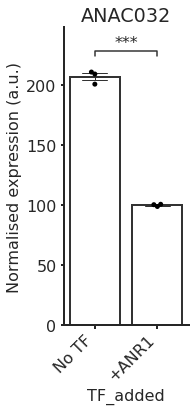

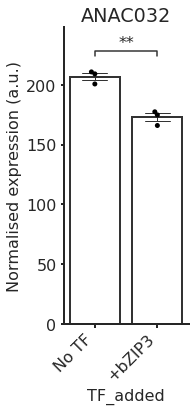

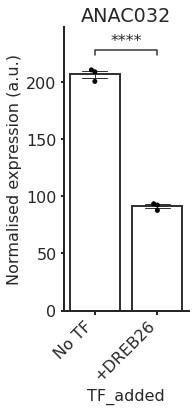

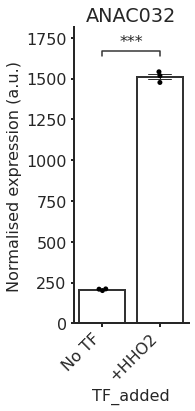

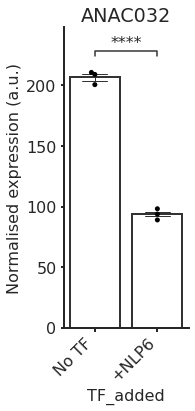

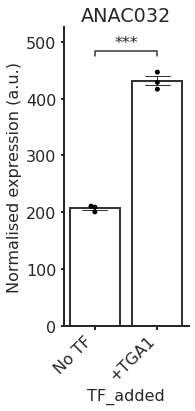

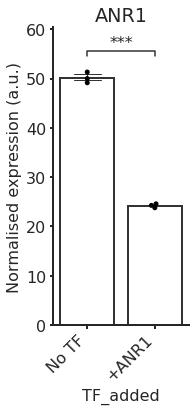

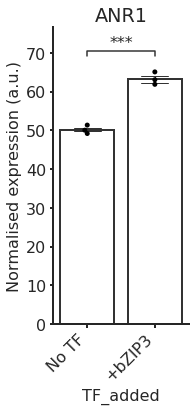

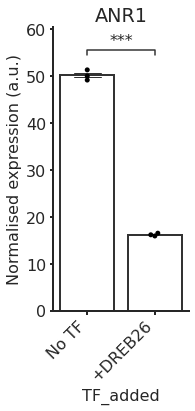

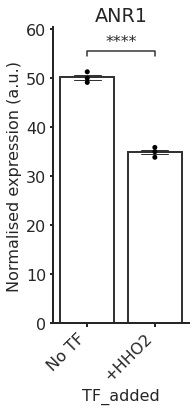

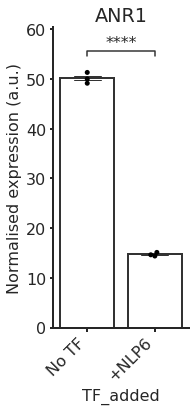

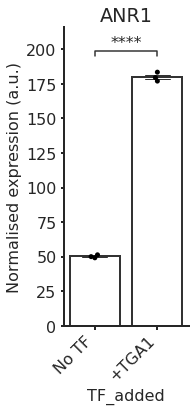

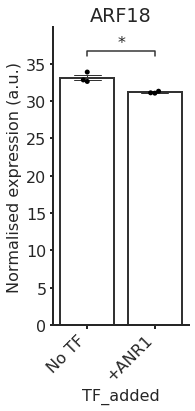

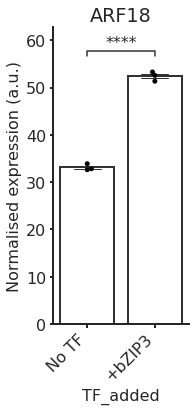

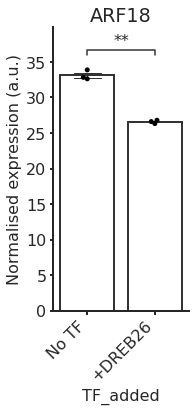

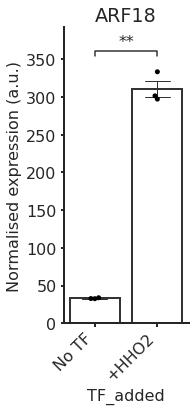

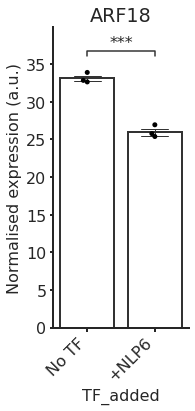

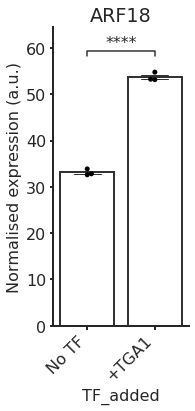

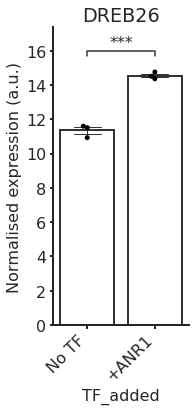

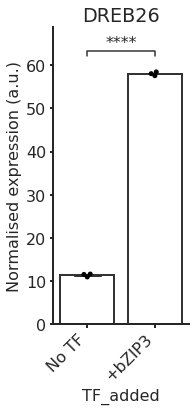

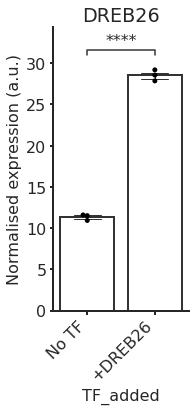

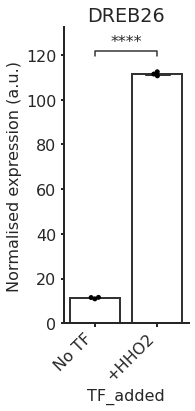

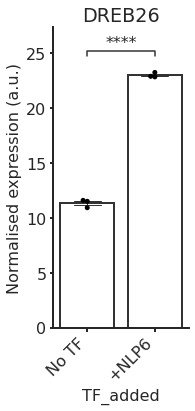

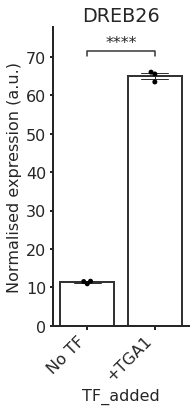

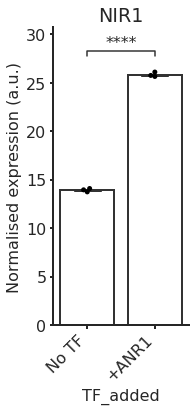

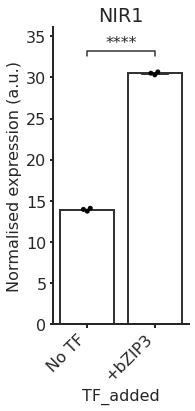

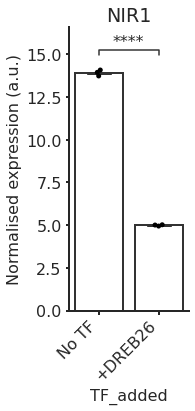

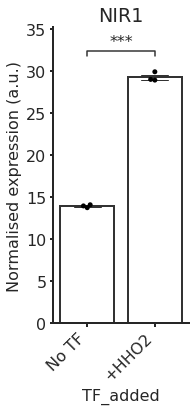

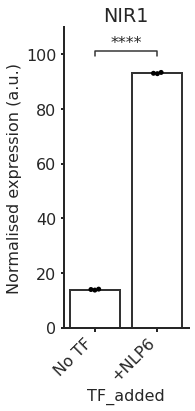

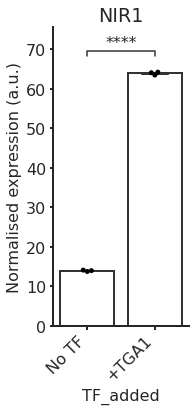

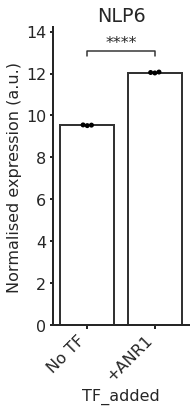

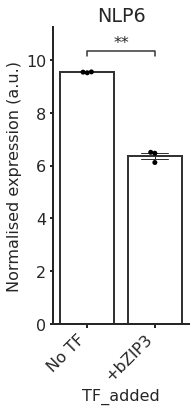

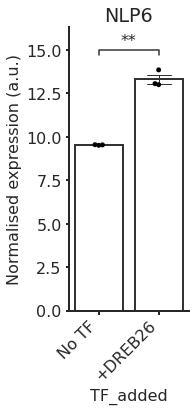

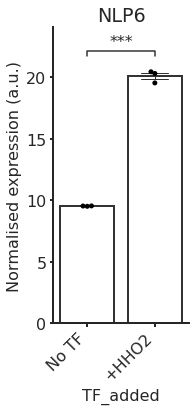

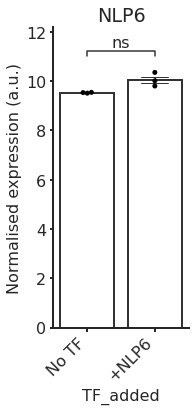

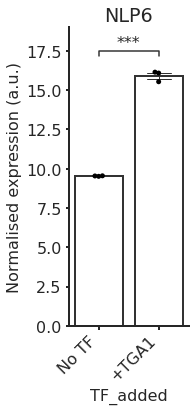

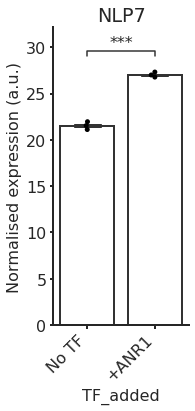

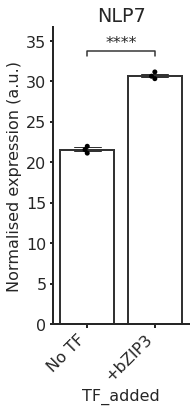

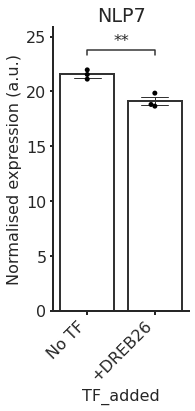

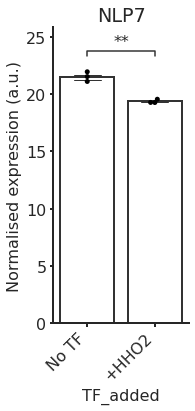

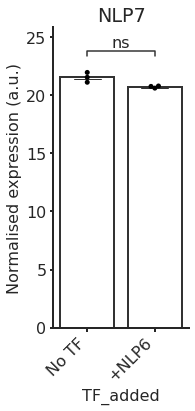

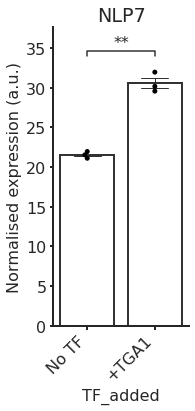

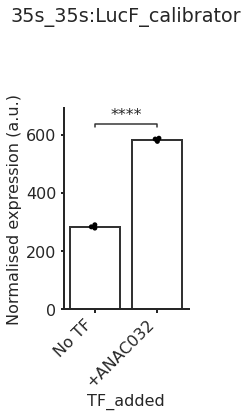

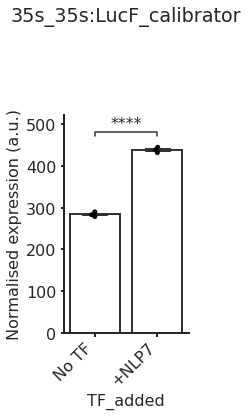

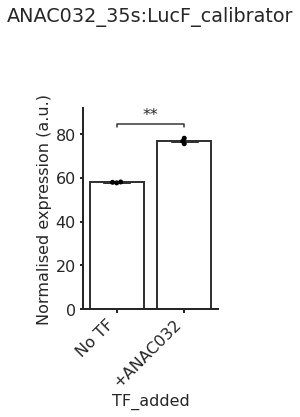

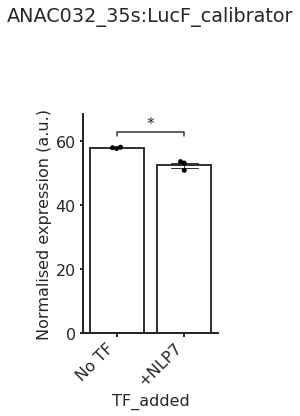

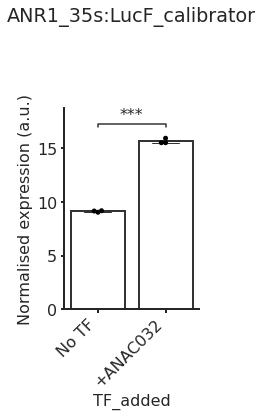

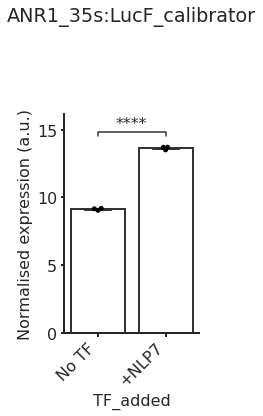

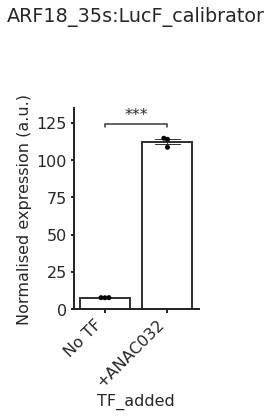

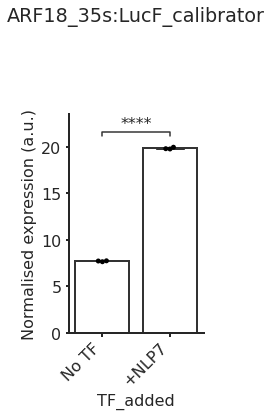

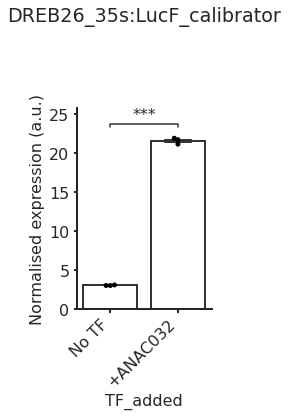

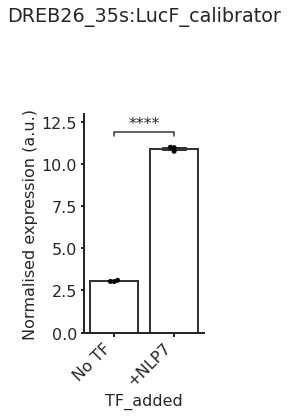

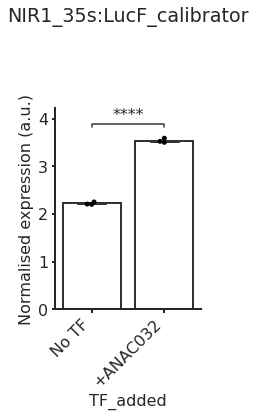

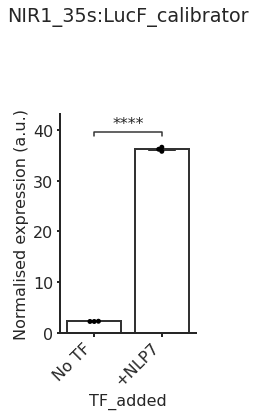

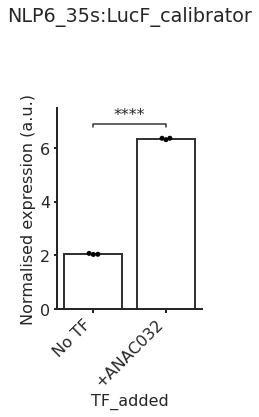

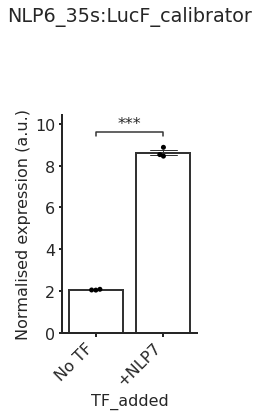

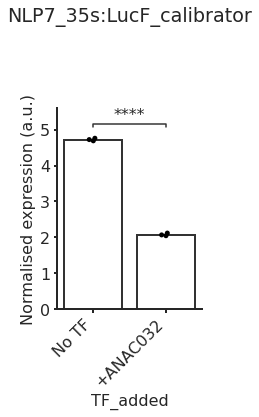

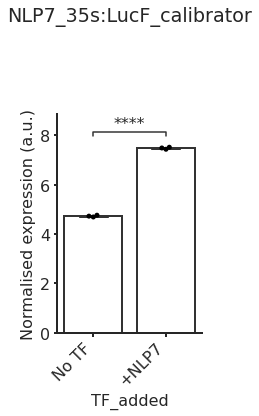

In [109]:
#make individual plots
#layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
#make graphs for each promoter
#color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
#plots for promoters with more than 2 Tf categories
#prom == 'minimal_STAP4'
#set matplotlib default parameters
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['axes.linewidth'] = 2
#rcParams['lines.linewidth'] = 2
#remove top and right lines
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
#font size
rcParams['font.size'] = 16
for prom in prom_names_plate1:
    if prom == 'NOS_calibrator' or prom == 'STAP4' or prom == 'NOS' or prom == 'minimal_STAP4' or prom == 'NOS_calibrator_35s:LucF_calibrator':
        pass
    else:
        df = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
        #split based on well calibrator
        if "_35s:LucF_calibrator" in prom:
            #get list of TFs coexpressed with that promoter
            TFs_orig =  df.TF_added.unique()
            #assign list of TFs of interest with this well calibrator
            TF_order = ['No TF','+ANAC032','+NLP7']
            #sort based on custom order
            TFs = []
            for i in range(len(TF_order)):
                if TF_order[i] in TFs_orig:
                    TFs+=[TF_order[i]]

            if len(TFs) < 2:
                pass
            else:
                for TF in TFs:
                    if TF == 'No TF':
                        pass
                    else:
                        
                        
                        #create new df with only TF of interest
                        df_new = df[(df.TF_added == TF) | (df.TF_added == 'No TF')]
                        #create box pairs
                        pair = [('No TF', TF)]
                        print(pair)
                        #pvalue = []
                    
                        # #create series objects
                        # TF1 = df_new.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
                        # TF2 = df_new.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
                        # # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
                        # # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
                        # #equal variance = false so do Welch's T-test
                        # results = stats.ttest_ind(TF1, TF2, equal_var=False)
                        #     #append pvalue to dict
                        # pvalue = results.pvalue
                        # # box_pairs_significant.append(pair)
                        # # p_values.append(results.pvalue)
                        # print(f'pvalue={pvalue}')

                        # # #filter dict by significance and put in a new dictionary
                        # # box_pairs_significant = {}
                        # # for k,v in box_pairs_all_pvalues.items():
                        # #     if v <0.05:
                        # #         box_pairs_significant[k] = v
                        


                        #make plot 
                        plt.figure(figsize=(3,6))
                        order_new = pair[0]
                        fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df_new, order=order_new, linewidth=2, facecolor=(1,1,1,1), errcolor=".2", edgecolor=".2", ci=68, errwidth=1,capsize=0.4)
                        sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df_new, order=order_new,color='black')
                        #add stats
                        annotator = Annotator(fig, pair, data=df_new, x='TF_added', y='corrected_luminescence',order=order_new)
                        annotator.configure(test='t-test_welch', text_format='star',)#loc='inside'
                        annotator.apply_and_annotate()



                        # if pvalue<0.05:

                        #     add_stat_annotation(
                        #     fig,
                        #     data=df_new,
                        #     x='TF_added',
                        #     y='corrected_luminescence',
                        #     order=order_new,
                        #     box_pairs=pair,
                        #     text_format="star",
                        #     loc="inside",
                        #     verbose=2,
                        #     perform_stat_test=False,
                        #     pvalues=list(pvalue),
                        #     #test='Mann-Whitney'
                        #     #test_short_name="Dunn",
                        #     )

                        # change axes labels
                        plt.ylabel('Normalised expression (a.u.)')
                        #add title
                        plt.title(prom, y=1.4,)
                        #make xticks diagonal
                        plt.xticks(rotation=45, ha='right')
                        #plt.xlabel(x_label)
                        # tight layout
                        plt.tight_layout()
                        # save figure
                        plt.savefig(
                            f'../../../../data/plots/luminescence/{date}/individual/calibrator_35s/scatter{prom}_{TF}_plate1.pdf',
                            format="pdf",
                            bbox_inches="tight",)

        else:            
            #df2 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
            #change name of TF added in df2 to minimal_stap4        
            #df2['TF_added'] = 'pSTAP4 no TF'
            # df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
            TFs_orig =  df.TF_added.unique()
            #print(TFs_orig)
            TF_order = ['No TF','+ANR1','+bZIP3','+DREB26','+HHO2','+NLP6','+TGA1']
            #'No TF/YFP','+No TF/YFP_1μM_NAA',
            #sort based on custom order
            TFs = []
            for i in range(len(TF_order)):
                if TF_order[i] in TFs_orig:
                    TFs+=[TF_order[i]]
            #print(TFs)
            #print(df)
            #get length of number of TFs
            #length_tf = len(TFs)
            #create order and box pairs based on the length of TFs
            #iterate through TFs
            #pass if only one TF
            if len(TFs) < 2:
                pass
            else:
                for TF in TFs:
                    if TF == 'No TF':
                        pass
                    else:
                        
                        
                        #create new df with only TF of interest
                        df_new = df[(df.TF_added == TF) | (df.TF_added == 'No TF')]
                        #create box pairs
                        pair = [('No TF', TF)]
                        print(pair)
                        #pvalue = []
                    
                        # #create series objects
                        # TF1 = df_new.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
                        # TF2 = df_new.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
                        # # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
                        # # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
                        # #equal variance = false so do Welch's T-test
                        # results = stats.ttest_ind(TF1, TF2, equal_var=False)
                        #     #append pvalue to dict
                        # pvalue = results.pvalue
                        # # box_pairs_significant.append(pair)
                        # # p_values.append(results.pvalue)
                        # print(f'pvalue={pvalue}')

                        # # #filter dict by significance and put in a new dictionary
                        # # box_pairs_significant = {}
                        # # for k,v in box_pairs_all_pvalues.items():
                        # #     if v <0.05:
                        # #         box_pairs_significant[k] = v
                        


                        #make plot 
                        plt.figure(figsize=(3,6))
                        order_new = pair[0]
                        fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df_new, order=order_new, linewidth=2, facecolor=(1,1,1,1), errcolor=".2", edgecolor=".2", ci=68, errwidth=1,capsize=0.4)
                        sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df_new, order=order_new,color='black')
                        #add stats
                        annotator = Annotator(fig, pair, data=df_new, x='TF_added', y='corrected_luminescence',order=order_new)
                        annotator.configure(test='t-test_welch', text_format='star',)#loc='inside'
                        annotator.apply_and_annotate()



                        # if pvalue<0.05:

                        #     add_stat_annotation(
                        #     fig,
                        #     data=df_new,
                        #     x='TF_added',
                        #     y='corrected_luminescence',
                        #     order=order_new,
                        #     box_pairs=pair,
                        #     text_format="star",
                        #     loc="inside",
                        #     verbose=2,
                        #     perform_stat_test=False,
                        #     pvalues=list(pvalue),
                        #     #test='Mann-Whitney'
                        #     #test_short_name="Dunn",
                        #     )

                        # change axes labels
                        plt.ylabel('Normalised expression (a.u.)')
                        #add title
                        plt.title(prom, y=1,)
                        #make xticks diagonal
                        plt.xticks(rotation=45, ha='right')
                        #plt.xlabel(x_label)
                        # tight layout
                        plt.tight_layout()
                        # save figure
                        plt.savefig(
                            f'../../../../data/plots/luminescence/{date}/individual/calibrator_nos/scatter{prom}_{TF}_plate1.pdf',
                            format="pdf",
                            bbox_inches="tight",)
                

            
            
            



ANAC032
['No TF', '+ARF9', '+ARF18', '+ARF18+ARF9', '+ARF18+IAA33', 'No TF_1μM_NAA', '+ARF9_1μM_NAA', '+ARF18_1μM_NAA', '+ARF18+ARF9_1μM_NAA', '+ARF18+IAA33_1μM_NAA']
xlength=10
ANR1
['No TF', '+ARF9', '+ARF18', '+ARF18+ARF9', '+ARF18+IAA33', 'No TF_1μM_NAA', '+ARF9_1μM_NAA', '+ARF18_1μM_NAA', '+ARF18+ARF9_1μM_NAA', '+ARF18+IAA33_1μM_NAA']
xlength=10
ARF18
['No TF', '+ARF18', '+ARF18+ARF9', '+ARF18+IAA33', 'No TF_1μM_NAA', '+ARF18_1μM_NAA', '+ARF18+ARF9_1μM_NAA', '+ARF18+IAA33_1μM_NAA']
xlength=8
DREB26
['No TF', '+ARF9', '+ARF18', '+ARF18+ARF9', '+ARF9+IAA33', '+ARF18+IAA33', '+ARF18+ARF9+IAA33', 'No TF_1μM_NAA', '+ARF9_1μM_NAA', '+ARF18_1μM_NAA', '+ARF18+ARF9_1μM_NAA', '+ARF9+IAA33_1μM_NAA', '+ARF18+IAA33_1μM_NAA', '+ARF18+ARF9+IAA33_1μM_NAA']
xlength=14
NIR1
['No TF', '+ARF9', '+ARF18', '+ARF18+ARF9', '+ARF9+IAA33', '+ARF18+IAA33', '+ARF18+ARF9+IAA33', 'No TF_1μM_NAA', '+ARF9_1μM_NAA', '+ARF18_1μM_NAA', '+ARF18+ARF9_1μM_NAA', '+ARF9+IAA33_1μM_NAA', '+ARF18+IAA33_1μM_NAA', '+ARF18+AR

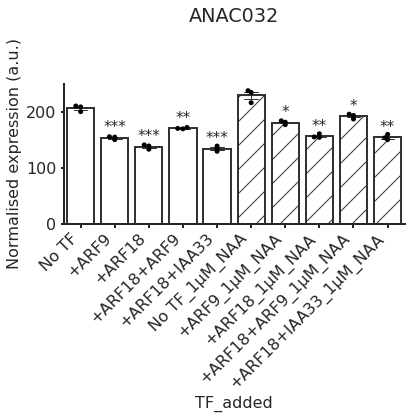

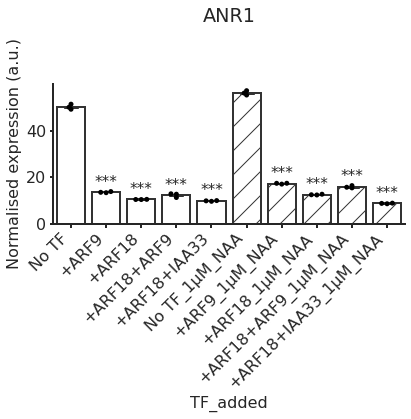

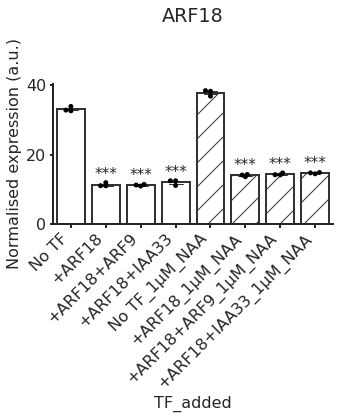

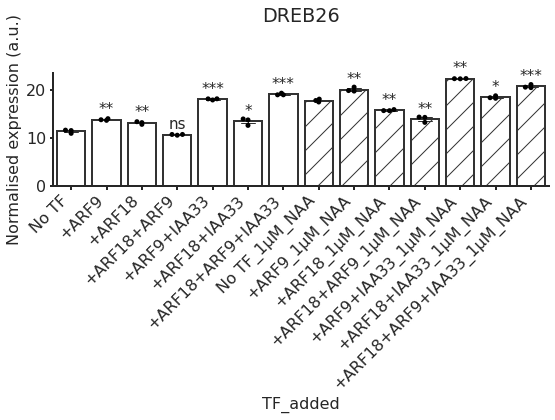

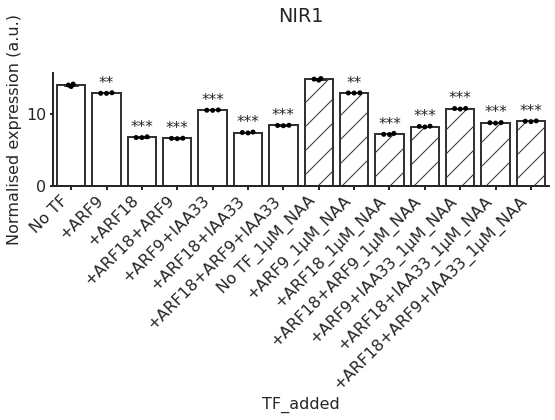

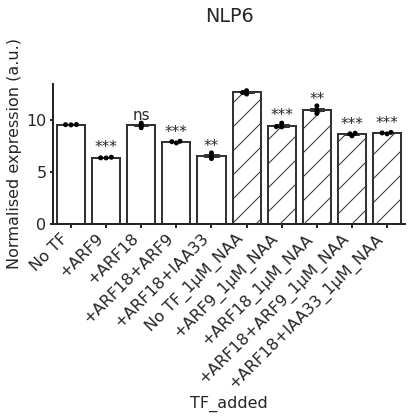

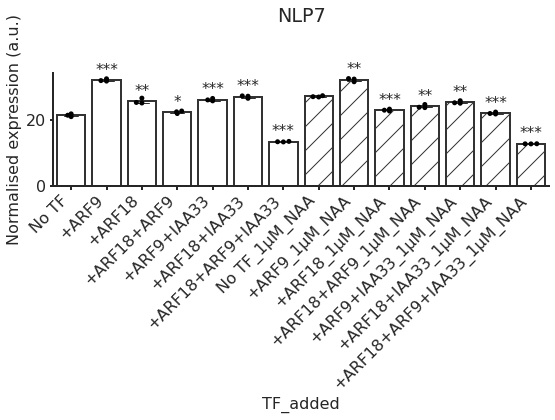

In [108]:
#make ARF plots
#layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
#make graphs for each promoter
#color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
#plots for promoters with more than 2 Tf categories
#prom == 'minimal_STAP4'
#set matplotlib default parameters
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['axes.linewidth'] = 2
#rcParams['lines.linewidth'] = 2
#remove top and right lines
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
#font size
rcParams['font.size'] = 16
for prom in prom_names_plate1:
    if prom == 'NOS_calibrator' or prom == 'NOS_calibrator_35s:LucF_calibrator' or prom == 'STAP4' or prom == 'NOS' or prom == 'minimal_STAP4':
        pass
    #if 35s calibrator in promoter name, skip promoter
    elif "_35s:LucF_calibrator" in prom:
        pass
    else:        
          
        df = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
        #df2 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
        #change name of TF added in df2 to minimal_stap4        
        #df2['TF_added'] = 'pSTAP4 no TF'
        #df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
        TFs_orig =  df.TF_added.unique()
        TF_order = ['No TF','+ARF9','+ARF18','+ARF18+ARF9','+ARF9+IAA33','+ARF18+IAA33','+ARF18+ARF9+IAA33','No TF_1μM_NAA','+ARF9_1μM_NAA','+ARF18_1μM_NAA','+ARF18+ARF9_1μM_NAA','+ARF9+IAA33_1μM_NAA','+ARF18+IAA33_1μM_NAA','+ARF18+ARF9+IAA33_1μM_NAA']
        #new_TF_order = ['No TF','+ARF9','+ARF18','+ARF18+ARF9','+ARF9+IAA33','+ARF18+IAA33','+ARF18+ARF9+IAA33','','No TF_1μM_NAA','+ARF9_1μM_NAA','+ARF18_1μM_NAA','+ARF18+ARF9_1μM_NAA','+ARF9+IAA33_1μM_NAA','+ARF18+IAA33_1μM_NAA','+ARF18+ARF9+IAA33_1μM_NAA']
        #'No TF/YFP','+No TF/YFP_1μM_NAA',
        #sort based on custom order
        TFs = []
        for i in range(len(TF_order)):
            if TF_order[i] in TFs_orig:
                TFs+=[TF_order[i]]
        #print(df)
        #get length of number of TFs
        length_tf = len(TFs)
        #create order and box pairs based on the length of TFs
        order = []
        box_pairs = []   
        for x in range (0, (length_tf)):
            order.append(TFs[x])
            if TFs[x] == "No TF" or TFs[x] == "No TF_1μM_NAA":
                pass
            #if auxin condition, use auxin control
            elif "_1μM_NAA" in TFs[x]:
                box_pairs.append(('No TF_1μM_NAA',TFs[x]))

            else:
                box_pairs.append(('No TF',TFs[x]))
        #add every combination of box pairs of length 2
        #box_pairs=list(combinations(order, 2))~
        #make box pairs dict with box pair and p value
        box_pairs_all_pvalues = {}
        #make dict containing the TF and p value compared to its control (either No TF with auxin or no auxin No TF)
        TFs_pvalues = {}
        for pair in box_pairs:
            #create series objects
            TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
            TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
        # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
        # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
        #equal variance = false so do Welch's T-test
            results = stats.ttest_ind(TF1, TF2, equal_var=False)
            #append pvalue to dict
            box_pairs_all_pvalues[pair] = results.pvalue
            TFs_pvalues[pair[1]] = results.pvalue
        # box_pairs_significant.append(pair)
        # p_values.append(results.pvalue)
        #print(f'all pvalues={box_pairs_all_pvalues}')

        # #filter dict by significance and put in a new dictionary
        box_pairs_significant = {}
        for k,v in box_pairs_all_pvalues.items():
            if v <0.05:
                box_pairs_significant[k] = v

        def convert_pvalue_to_asterisks(pvalue):
            if pvalue <= 0.001:
                return "***"
            elif pvalue <= 0.01:
                return "**"
            elif pvalue <= 0.05:
                return "*"
            return "ns"
        #print(df.columns)
        #'well', 'content', 'fluc_luminescence', 'nluc_luminescence', 'well_row',
    #    'well_col', 'name', 'condition', 'nluc/fluc', 'date', 'Promoter',
    #    'TF_added', 'Well_calibrator', 'Plate_number',
    #    'corrected_luminescence'
        #add a blank data point in between non-auxin and auxin conditions

        #new_df = pd.concat([df[df.condition == 'nitrogen'], pd.DataFrame({'well':[''],'content':[''],'fluc_luminescence':[0],'nluc_luminescence':[0], 'well_row':[''],'well_col':[0], 'name':[''], 'condition':['nitrogen'], 'nluc/fluc':[0], 'date':[''], 'Promoter':[prom],'TF_added':[''], 'Well_calibrator':[''], 'Plate_number':[0],'corrected_luminescence':[0]}, df[df.condition == '1uM_auxin'])])

        # #rename x values
        # names = df.TF_added.unique()
        # #Change TF names to +TF
        # df_renamed = df.copy()
        # for TF in names:
        #     if '_1μM_NAA' in TF:
        #         new_name = TF[:len(TF)-8]
        #         df_renamed.TF_added.replace(TF,new_name, inplace=True)
        
        # if len(TFs) is 3:
        #     order = [TFs[0],TFs[1],TFs[2]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
        # elif len(TFs) is 4:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
        # elif len(TFs) is 5:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
        # elif len(TFs) is 6:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
        # elif len(TFs) is 7:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
        # elif len(TFs) is 8:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


        if len(TFs) == 2:
            #plt.figure()
            plt.figure(figsize=((length_tf-(length_tf//2)+2),6))
            #order_new = [TFs[0],TFs[1]]
            
            fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, facecolor=(1,1,1,1), errcolor=".2", edgecolor=".2", ci=68, errwidth=1,capsize=0.4, dodge=True)

            sns.swarmplot(x='TF_added', y='corrected_luminescence',data=df, order=order,color='black',dodge=True,)
            #fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order_new)


            # fig = sns.catplot(
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     data=df,
            #     kind='violin',
            #     order=order,            
            #     cut=0,
            #     legend=False,
            #     #color=new_color
            # )
            
            #fig = px.violin(df, x='TF_added',
            #                         y='corrected_luminescence', box=True,                       
            #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

            #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
            #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
            #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
            #hide legend
            #fig.layout.update(showlegend=False)
            # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
            #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
            # label box pairs        
            #box_pairs = [(TFs[0],TFs[1])]
            
            # make empty list of p_values
           # p_values = []
            # populate the list of p_values according to the box_pairs
            # for pair in box_pairs:
            #     print(pair)
            #     # select p value for each pair
            #     p = stat.loc[pair[0], pair[1]]
            #     p_values.append(p)

            # add stats annotation to the plot
            # add_stat_annotation(
            #     fig,
            #     data=df,
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     order=order_new,
            #     box_pairs=list(box_pairs_significant.keys()),
            #     text_format="star",
            #     loc="outside",
            #     verbose=2,
            #     perform_stat_test=False,
            #     pvalues=list(box_pairs_significant.values()),
            #     #test='Mann-Whitney',
            # )
            # # change axes labels
            # plt.ylabel('Normalised expression (a.u.)')
            # #add title
            # plt.title(prom)
            # #make xticks diagonal
            # plt.xticks(rotation=45, ha='right')
            # #plt.xlabel(x_label)
            # # tight layout
            # plt.tight_layout()
            # # save figure
            # plt.savefig(
            #     f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
            #     format="pdf",
            #     bbox_inches="tight",
           # )
        elif len(TFs) < 2:
            pass
        else:
            print(prom)
            print(TFs)
            plt.figure(figsize=((length_tf-(length_tf//2)+1),6))
            # fig = sns.catplot(
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     data=df,
            #     kind='violin',
            #     order=order,            
            #     cut=0,
            #     legend=False,
            #     #color=new_color
            # )
            fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, facecolor=(1,1,1,1), errcolor=".2", edgecolor=".2", ci=68, errwidth=1,capsize=0.4,dodge=True)
           
            sns.swarmplot(x='TF_added', y='corrected_luminescence',data=df, order=order,color='black',dodge=True)
            
            #fig = px.violin(df, x='TF_added',
            #                         y='corrected_luminescence', box=True,                       
            #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

            #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
            #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
            #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
            #hide legend
            #fig.layout.update(showlegend=False)
            # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
            # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
            # # label box pairs        
            # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
            # # make empty list of p_values
            # p_values = []
            # # populate the list of p_values according to the box_pairs
            # for pair in box_pairs:
            # #    print(pair)
            #     # select p value for each pair
            #     p = stat.loc[pair[0], pair[1]]
            #     p_values.append(p)

            # add stats annotation to the plot
        #add stats
        #print(box_pairs)
        #if no significant values, don't add stats annotation

        


        if len(box_pairs_significant.values()) < 1:
            pass
        else:
            pass
            # #add a gap between no auxin and auxin conditions
            # #first identify No TF_1μM_NAA X position
            # middle = order.index("No TF_1μM_NAA")
            # #then modify x locations with a gap before the auxin no tf position

            # x_locations = list(range(0,middle))+list(range(middle+1,len(order)+1))
            # print(x_locations)
            # plt.xticks(x_locations,order)
            
            #plt.bar_label(box_pairs_all_pvalues.values())
            #get x length
            xlength=len(fig.patches)
            print(f'xlength={xlength}')
            #add patterned hatching to the bars length_tf
            hatches = itertools.cycle(['/','//','+','\\','*','o','O','.'])
            #also add asterisks for p values
            #make empty variable to show when No TF_1μM_NAA has been iterated over
            auxin_control_picked = False
            for x in range (0, (xlength)):
                current_TF = order[x]
                if current_TF == "No TF" or current_TF == '':                
                    pass
                elif current_TF == "No TF_1μM_NAA":
                    auxin_control_picked = True
                    fig.patches[x].set_hatch(hatch)
                else:
                    pvalue = TFs_pvalues[current_TF]

                    
                # pvalue = list(box_pairs_all_pvalues.values())[x]
                    #key=list(box_pairs_all_pvalues.keys())[x][1]
                    p = fig.patches[x]
                    fig.annotate(convert_pvalue_to_asterisks(pvalue),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    size=15,
                    xytext = (0, 10), 
                    textcoords = 'offset points')
                    #add patterned hatching to the bars length_tf
                    if auxin_control_picked == True:
                        p.set_hatch(hatch)
             
            # hatches = itertools.cycle(['/','//','+','\\','*','o','O','.'])
            # for i, bar in enumerate(fig.patches):
            #     print(f'i={i},bar={bar}')
            #     if i % length_tf == 0:
            #         hatch = next(hatches)
            #     bar.set_hatch(hatch)
            # y_position = df['corrected_luminescence'].max()
            # for k, v in box_pairs_all_pvalues.items():
            #     plt.text(x=k[1], y=y_position, s=convert_pvalue_to_asterisks(v))
            # #annotator = Annotator(fig, pairs=list(box_pairs), data=df, x='TF_added', y='corrected_luminescence',order=order,)
            # annotator = Annotator(fig, pairs=list(box_pairs_significant.keys()), data=df, x='TF_added', y='corrected_luminescence',order=order,)
            # #annotator.set_pvalues(list(box_pairs))
            # annotator.set_pvalues(list(box_pairs_significant.values()))
            # #annotator.configure(test='Mann-Whitney',verbose=2,text_format='star', loc='inside',)#loc='inside'
            # #annotator.apply_and_annotate()
            # annotator.annotate()


            #if no significant values, don't add stats annotation
        # if len(box_pairs_significant.values()) < 1:
        #     pass
        # else:
        #     add_stat_annotation(
        #         fig,
        #         data=df,
        #         x='TF_added',
        #         y='corrected_luminescence',
        #         order=order,
        #         box_pairs=list(box_pairs_significant.keys()),
        #         text_format="star",
        #         loc="outside",
        #         verbose=2,
        #         perform_stat_test=False,
        #         pvalues=list(box_pairs_significant.values()),
        #         #test_short_name="Dunn",
        #     )
        
        # change axes labels
        plt.ylabel('Normalised expression (a.u.)')
        #add title
        plt.title(prom, y=1.4,)
        #make xticks diagonal
        plt.xticks(rotation=45, ha='right')
        #plt.xlabel(x_label)
        # tight layout
        plt.tight_layout()
        # save figure
        plt.savefig(
            f'../../../../data/plots/luminescence/{date}/scatter{prom}_ARFs_plate1.pdf',
            format="pdf",
            bbox_inches="tight",)
 
            


            #write to file static image and interactive one
        # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
        #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
        #  fig.show()

TFs_orig_renamed=['No TF' 'No TF/YFP' '+bZIP3' '+TGA1' '+No TF/YFP' '+NLP7' '+NLP6' '+HHO2'
 '+DREB26' '+ARF9' '+ARF18' '+ARF18+IAA33' '+ARF18+ARF9' '+ANR1'
 '+ANAC032']
[[('No TF', '1uM_auxin'), ('No TF', 'nitrogen')], [('+ARF9', '1uM_auxin'), ('+ARF9', 'nitrogen')], [('+ARF18', '1uM_auxin'), ('+ARF18', 'nitrogen')], [('+ARF18+ARF9', '1uM_auxin'), ('+ARF18+ARF9', 'nitrogen')], [('+ARF18+IAA33', '1uM_auxin'), ('+ARF18+IAA33', 'nitrogen')]]
ANAC032
['No TF', '+ARF9', '+ARF18', '+ARF18+ARF9', '+ARF18+IAA33']
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

+ARF9_1uM_auxin vs. +ARF9_nitrogen: Welch's t-test independent samples, P_val:5.696e-04 t=1.050e+01
No TF_1uM_auxin vs. No TF_nitrogen: Welch's t-test independent samples, P_val:5.647e-02 t=3.127e+00
+ARF18_1uM_auxin vs. +ARF18_nitrogen: Welch's t-test independent samples, P_val:3.619e-03 t=6.229e+00
+ARF1

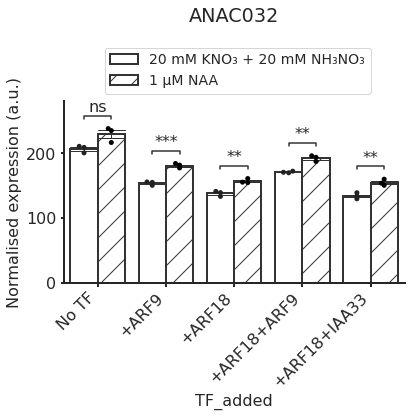

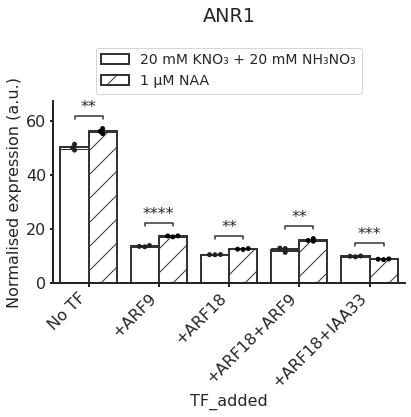

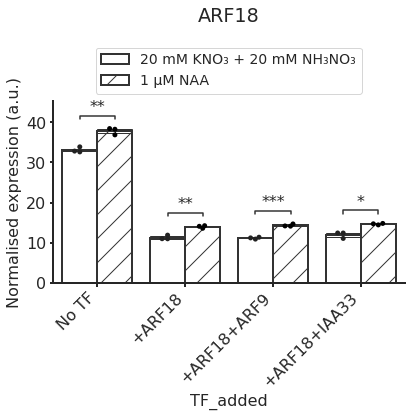

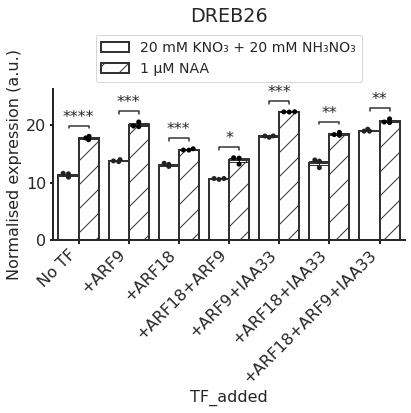

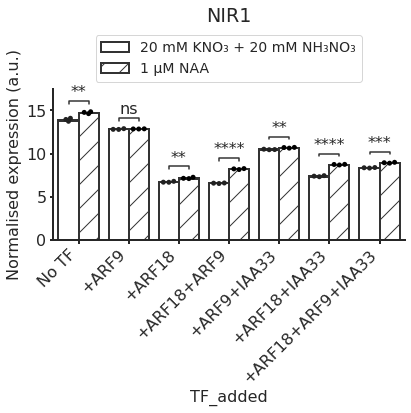

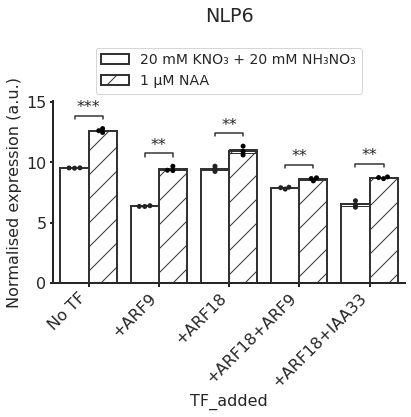

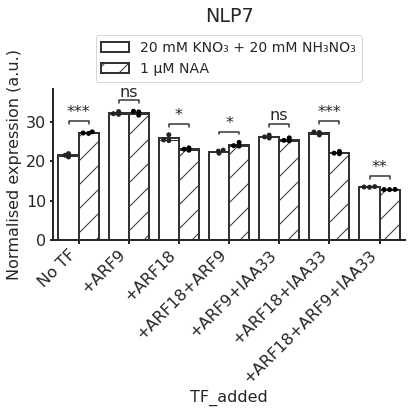

In [100]:
#ARF plots compare NAA
#make ARF plots
#layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
#make graphs for each promoter
#color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
#plots for promoters with more than 2 Tf categories
#prom == 'minimal_STAP4'
#set matplotlib default parameters
#set white bar colour
#sns.set_style('ticks')
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['axes.linewidth'] = 2
#rcParams['lines.linewidth'] = 2
#remove top and right lines
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False


#font size
rcParams['font.size'] = 16
for prom in prom_names_plate1:
    if prom == 'NOS_calibrator' or prom == 'NOS_calibrator_35s:LucF_calibrator' or prom == 'STAP4' or prom == 'NOS' or prom == 'minimal_STAP4':
        pass
    #if 35s calibrator in promoter name, skip promoter
    elif "_35s:LucF_calibrator" in prom:
        pass
    else:        
          
        df = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
        #df2 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
        #change name of TF added in df2 to minimal_stap4        
        #df2['TF_added'] = 'pSTAP4 no TF'
        #df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
        TFs_orig =  df.TF_added.unique()
        TF_order = ['No TF','+ARF9','+ARF18','+ARF18+ARF9','+ARF9+IAA33','+ARF18+IAA33','+ARF18+ARF9+IAA33']
        #new_TF_order = ['No TF','+ARF9','+ARF18','+ARF18+ARF9','+ARF9+IAA33','+ARF18+IAA33','+ARF18+ARF9+IAA33','No TF_1μM_NAA','+ARF9_1μM_NAA','+ARF18_1μM_NAA','+ARF18+ARF9_1μM_NAA','+ARF9+IAA33_1μM_NAA','+ARF18+IAA33_1μM_NAA','+ARF18+ARF9+IAA33_1μM_NAA']
        #'No TF/YFP','+No TF/YFP_1μM_NAA',
        #sort based on custom order
        # TFs_notrenamed = []
        # for i in range(len(TF_order)):
        #     if TF_order[i] in TFs_orig:
        #         TFs_notrenamed+=[TF_order[i]]
        #rename x values
        #TFs_orig = df.TF_added.unique()
       
        #Change TF names to +TF
        df_renamed = df.copy()
        for TF in TFs_orig:
            if '_1μM_NAA' in TF:
                TFs_orig_renamed = TF[:len(TF)-8]
                df_renamed.TF_added.replace(TF,TFs_orig_renamed, inplace=True)

        TFs_renamed =  df_renamed.TF_added.unique()
        print(f'TFs_orig_renamed={TFs_renamed}')

        TFs = []
        for i in range(len(TF_order)):
            if TF_order[i] in TFs_renamed:
                TFs+=[TF_order[i]]
        #print(df)
        #get length of number of TFs
        length_tf = len(TFs)
        #create order and box pairs based on the length of TFs
        order = []
        box_pairs = []   
        for x in range (0, (length_tf)):
            order.append(TFs[x])
            box_pairs.append([(TFs[x],'1uM_auxin'),(TFs[x],'nitrogen')])
        print(box_pairs)
        

        #do the same again for the TFs with auxin before they were renamed
        
        # box_pairs_not_renamed = []
        # for TF in TFs_renamed:
        #     box_pairs_not_renamed.append((TF,f'{TF}_1μM_NAA'))
       
        
        #add every combination of box pairs of length 2
        #box_pairs=list(combinations(order, 2))~
        #make box pairs dict with box pair and p value
       # box_pairs_all_pvalues = {}
        #make dict containing the TF and p value compared to its control (either No TF with auxin or no auxin No TF)
        # TFs_pvalues = {}
        # for pair in box_pairs_not_renamed:
        #     #create series objects
        #     TF1 = df_renamed.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
        #     TF2 = df_renamed.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
        # # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
        # # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
        # #equal variance = false so do Welch's T-test
        #     results = stats.ttest_ind(TF1, TF2, equal_var=False)
        #     #append pvalue to dict
        #     box_pairs_all_pvalues[pair] = results.pvalue
        #     #TFs_pvalues[pair[1]] = results.pvalue
        # # box_pairs_significant.append(pair)
        # p_values.append(results.pvalue)
        #print(f'all pvalues={box_pairs_all_pvalues}')

        # #filter dict by significance and put in a new dictionary
        # box_pairs_significant = {}
        # for k,v in box_pairs_all_pvalues.items():
        #     if v <0.05:
        #         box_pairs_significant[k] = v

        # def convert_pvalue_to_asterisks(pvalue):
        #     if pvalue <= 0.001:
        #         return "***"
        #     elif pvalue <= 0.01:
        #         return "**"
        #     elif pvalue <= 0.05:
        #         return "*"
        #     return "ns"
        #print(df.columns)
        #'well', 'content', 'fluc_luminescence', 'nluc_luminescence', 'well_row',
    #    'well_col', 'name', 'condition', 'nluc/fluc', 'date', 'Promoter',
    #    'TF_added', 'Well_calibrator', 'Plate_number',
    #    'corrected_luminescence'
        #add a blank data point in between non-auxin and auxin conditions

        #new_df = pd.concat([df[df.condition == 'nitrogen'], pd.DataFrame({'well':[''],'content':[''],'fluc_luminescence':[0],'nluc_luminescence':[0], 'well_row':[''],'well_col':[0], 'name':[''], 'condition':['nitrogen'], 'nluc/fluc':[0], 'date':[''], 'Promoter':[prom],'TF_added':[''], 'Well_calibrator':[''], 'Plate_number':[0],'corrected_luminescence':[0]}, df[df.condition == '1uM_auxin'])])

       
        
        # if len(TFs) is 3:
        #     order = [TFs[0],TFs[1],TFs[2]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
        # elif len(TFs) is 4:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
        # elif len(TFs) is 5:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
        # elif len(TFs) is 6:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
        # elif len(TFs) is 7:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
        # elif len(TFs) is 8:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


        if len(TFs) == 2:
            #plt.figure()
            plt.figure(figsize=((length_tf-(length_tf//2)+2),6))
            #order_new = [TFs[0],TFs[1]]
            
            fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df_renamed, hue='condition',hue_order=['nitrogen','1uM_auxin'], order=order, linewidth=2, errcolor=".2", edgecolor=".2", ci=68, errwidth=1,capsize=0.4, dodge=True,facecolor=(1,1,1,1))#
            #add patterned hatching to the bars length_tf
            hatches = itertools.cycle(['','/','//','+','\\','*','o','O','.'])
            for i, bar in enumerate(fig.patches):
                if i % length_tf == 0:
                    hatch = next(hatches)
                bar.set_hatch(hatch)
            
            #get handles and labels
            handles = fig.legend_.legendHandles
            labels = [text.get_text() for text in fig.legend_.texts]
            sns.swarmplot(x='TF_added', y='corrected_luminescence',data=df_renamed,hue='condition',hue_order=['nitrogen','1uM_auxin'],color='black', order=order,dodge=True)#,
            #fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order_new)


            # fig = sns.catplot(
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     data=df,
            #     kind='violin',
            #     order=order,            
            #     cut=0,
            #     legend=False,
            #     #color=new_color
            # )
            
            #fig = px.violin(df, x='TF_added',
            #                         y='corrected_luminescence', box=True,                       
            #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

            #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
            #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
            #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
            #hide legend
            #fig.layout.update(showlegend=False)
            # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
            #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
            # label box pairs        
            #box_pairs = [(TFs[0],TFs[1])]
            
            # make empty list of p_values
           # p_values = []
            # populate the list of p_values according to the box_pairs
            # for pair in box_pairs:
            #     print(pair)
            #     # select p value for each pair
            #     p = stat.loc[pair[0], pair[1]]
            #     p_values.append(p)

            # add stats annotation to the plot
            # add_stat_annotation(
            #     fig,
            #     data=df,
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     order=order_new,
            #     box_pairs=list(box_pairs_significant.keys()),
            #     text_format="star",
            #     loc="outside",
            #     verbose=2,
            #     perform_stat_test=False,
            #     pvalues=list(box_pairs_significant.values()),
            #     #test='Mann-Whitney',
            # )
            # # change axes labels
            # plt.ylabel('Normalised expression (a.u.)')
            # #add title
            # plt.title(prom)
            # #make xticks diagonal
            # plt.xticks(rotation=45, ha='right')
            # #plt.xlabel(x_label)
            # # tight layout
            # plt.tight_layout()
            # # save figure
            # plt.savefig(
            #     f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
            #     format="pdf",
            #     bbox_inches="tight",
           # )
        elif len(TFs) < 2:
            pass
        else:
            print(prom)
            print(TFs)
            plt.figure(figsize=(6,6))
            # fig = sns.catplot(
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     data=df,
            #     kind='violin',
            #     order=order,            
            #     cut=0,
            #     legend=False,
            #     #color=new_color
            # )
            fig = sns.barplot(x='TF_added', y='corrected_luminescence',hue='condition',hue_order=['nitrogen','1uM_auxin'], data=df_renamed, order=order, linewidth=2,  errcolor=".2", edgecolor=".2", ci=68, errwidth=1,capsize=0.4,dodge=True,facecolor=(1,1,1,1))#,
            #add patterned hatching to the bars length_tf
            hatches = itertools.cycle(['','/','//','+','\\','*','o','O','.'])
            for i, bar in enumerate(fig.patches):
                if i % length_tf == 0:
                    hatch = next(hatches)
                bar.set_hatch(hatch)
            
            # #get handles and labels
            # handles = fig.legend_.legendHandles
            # labels = [text.get_text() for text in fig.legend_.texts]
            sns.swarmplot(x='TF_added', y='corrected_luminescence',hue='condition',hue_order=['nitrogen','1uM_auxin'],data=df_renamed,color='black', order=order,dodge=True,)#,
            
            #fig = px.violin(df, x='TF_added',
            #                         y='corrected_luminescence', box=True,                       
            #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

            #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
            #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
            #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
            #hide legend
            #fig.layout.update(showlegend=False)
            # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
            # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
            # # label box pairs        
            # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
            # # make empty list of p_values
            # p_values = []
            # # populate the list of p_values according to the box_pairs
            # for pair in box_pairs:
            # #    print(pair)
            #     # select p value for each pair
            #     p = stat.loc[pair[0], pair[1]]
            #     p_values.append(p)

            # add stats annotation to the plot
        #add stats
        #print(box_pairs)
        #if no significant values, don't add stats annotation

        


        # if len(box_pairs_significant.values()) < 1:
        #     pass
        # else:
        #     pass
        #     # #add a gap between no auxin and auxin conditions
        #     # #first identify No TF_1μM_NAA X position
        #     # middle = order.index("No TF_1μM_NAA")
        #     # #then modify x locations with a gap before the auxin no tf position

            # x_locations = list(range(0,middle))+list(range(middle+1,len(order)+1))
            # print(x_locations)
            # plt.xticks(x_locations,order)
            
            #plt.bar_label(box_pairs_all_pvalues.values())
            #get x length
            # xlength=len(fig.patches)
            # print(f'xlength={xlength}')
            # print(box_pairs_all_pvalues)
            # for x in range (0, (xlength)):
            #     current_TF = order[x]    

            #     pvalue = TFs_pvalues[current_TF]                   
            #     # pvalue = list(box_pairs_all_pvalues.values())[x]
            #         #key=list(box_pairs_all_pvalues.keys())[x][1]
            #     p = fig.patches[x]
            #     fig.annotate(convert_pvalue_to_asterisks(pvalue),
            #     (p.get_x() + p.get_width() / 2., p.get_height()),
            #     ha = 'center', va = 'center',
            #     size=15,
            #     xytext = (0, 10), 
            #     textcoords = 'offset points')
            
            # y_position = df['corrected_luminescence'].max()
            # for k, v in box_pairs_all_pvalues.items():
            #     plt.text(x=k[1], y=y_position, s=convert_pvalue_to_asterisks(v))
        annotator = Annotator(fig, pairs=list(box_pairs), data=df_renamed, x='TF_added', y='corrected_luminescence',order=order,hue='condition')
        #annotator = Annotator(fig, pairs=list(box_pairs_significant.keys()), data=df, x='TF_added', y='corrected_luminescence',order=orderhue='condition')
        #annotator.set_pvalues(list(box_pairs),data=df, x='TF_added', y='corrected_luminescence',order=order,hue='condition')
        #annotator.set_pvalues(list(box_pairs_significant.values()))
        #annotator.configure(test='Mann-Whitney',verbose=2,text_format='star', loc='inside',).apply_and_annotate()#loc='inside'
        annotator.configure(test='t-test_welch',verbose=2,text_format='star', loc='inside',).apply_and_annotate()

            #annotator.annotate()


            #if no significant values, don't add stats annotation
        # if len(box_pairs_significant.values()) < 1:
        #     pass
        # else:
        #     add_stat_annotation(
        #         fig,
        #         data=df,
        #         x='TF_added',
        #         y='corrected_luminescence',
        #         order=order,
        #         box_pairs=list(box_pairs_significant.keys()),
        #         text_format="star",
        #         loc="outside",
        #         verbose=2,
        #         perform_stat_test=False,
        #         pvalues=list(box_pairs_significant.values()),
        #         #test_short_name="Dunn",
        #     )
        
        #plot legend, excluding legend from swarm plot
        h,l = fig.get_legend_handles_labels()
        #change name of label
        l[3] = "1 µM NAA"
        l[2] = "20 mM KNO\u2083 + 20 mM NH\u2083NO\u2083"        
        plt.legend(h[2:4],l[2:4],bbox_to_anchor=(0.1,1), loc='lower left',fontsize=14)
        #plt.legend()
        # change axes labels
        plt.ylabel('Normalised expression (a.u.)')
        #add title
        plt.title(prom, y=1.4,)
        #make xticks diagonal
        plt.xticks(rotation=45, ha='right')
        #plt.xlabel(x_label)
        # tight layout
        plt.tight_layout()
        # save figure
        plt.savefig(
            f'../../../../data/plots/luminescence/{date}/compare_auxin/scatter{prom}_ARFs_NAAcompare_plate1.pdf',
            format="pdf",
            bbox_inches="tight",)
 
            


            #write to file static image and interactive one
        # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
        #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
        #  fig.show()

all pvalues={('No TF', 'No TF/YFP'): 0.010732564172290777, ('No TF', '+No TF/YFP_1μM_NAA'): 0.00991992612147128, ('No TF', 'No TF_1μM_NAA'): 0.13729882297582086, ('No TF', '+ANAC032'): 1.570179906682451e-05, ('No TF', '+ARF18'): 0.6660049309949642, ('No TF', '+ARF18_1μM_NAA'): 0.185138482209562, ('No TF', '+ARF18+IAA33'): 0.08237623891635498, ('No TF', '+ARF18+IAA33_1μM_NAA'): 0.029142356610686846, ('No TF', '+ARF9'): 0.08522170104133074, ('No TF', '+ARF9_1μM_NAA'): 0.009297742662272127, ('No TF', '+NLP6'): 0.0043735178838963246, ('No TF', '+NLP7'): 0.09121526982997592}
NOS
['No TF/YFP', '+No TF/YFP_1μM_NAA', 'No TF', 'No TF_1μM_NAA', '+ANAC032', '+ARF18', '+ARF18_1μM_NAA', '+ARF18+IAA33', '+ARF18+IAA33_1μM_NAA', '+ARF9', '+ARF9_1μM_NAA', '+NLP6', '+NLP7']
all pvalues={('No TF', 'No TF/YFP'): 0.004204599872417448, ('No TF', '+No TF/YFP_1μM_NAA'): 0.0031045907689177823, ('No TF', 'No TF_1μM_NAA'): 0.05647246574086548, ('No TF', '+ANAC032'): 2.5309054749088317e-05, ('No TF', '+ANR1'): 0.

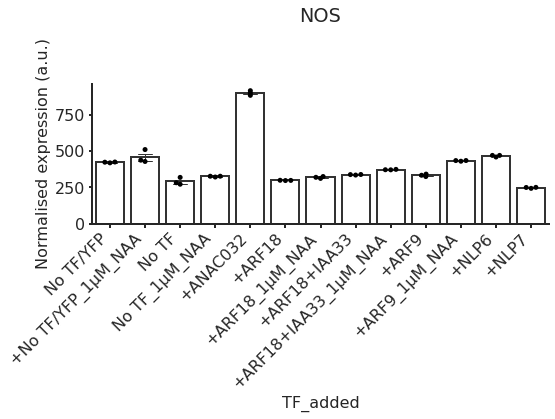

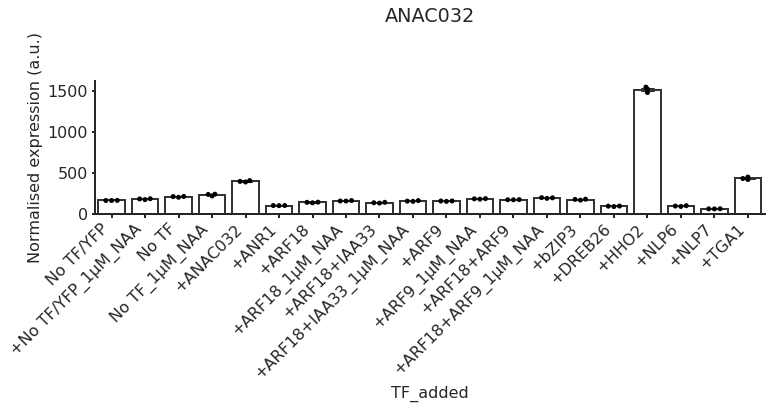

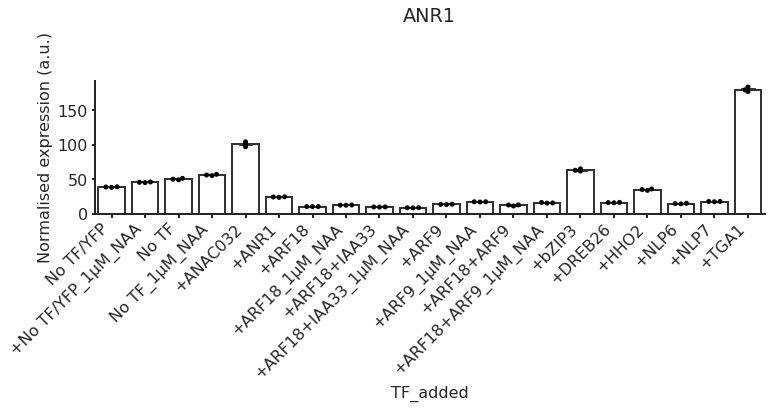

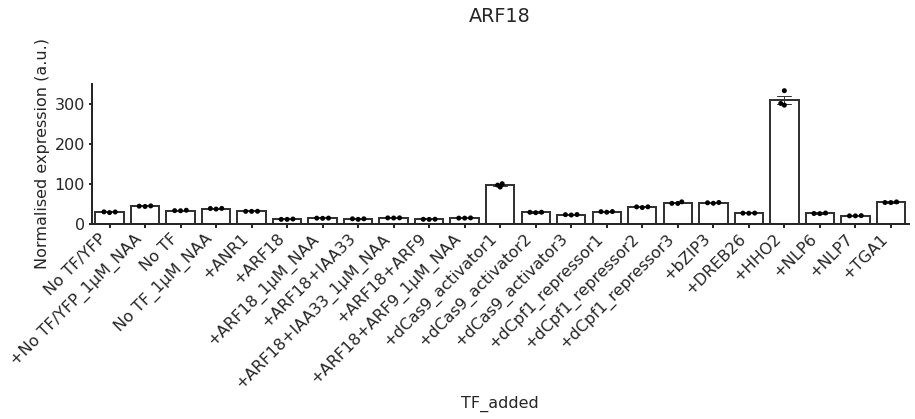

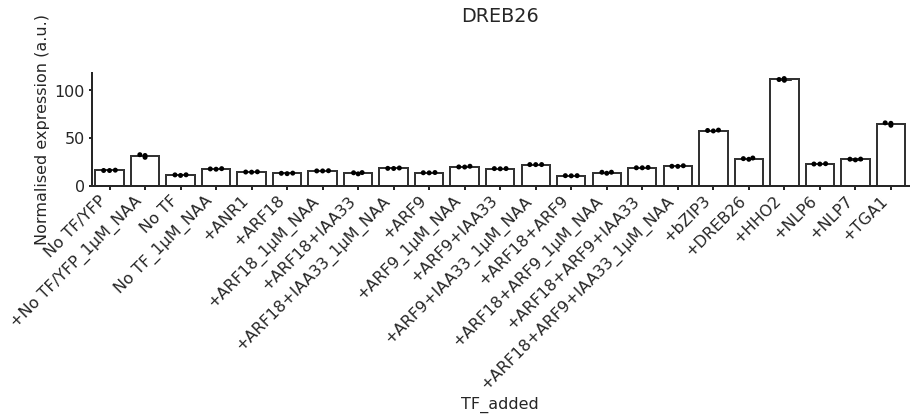

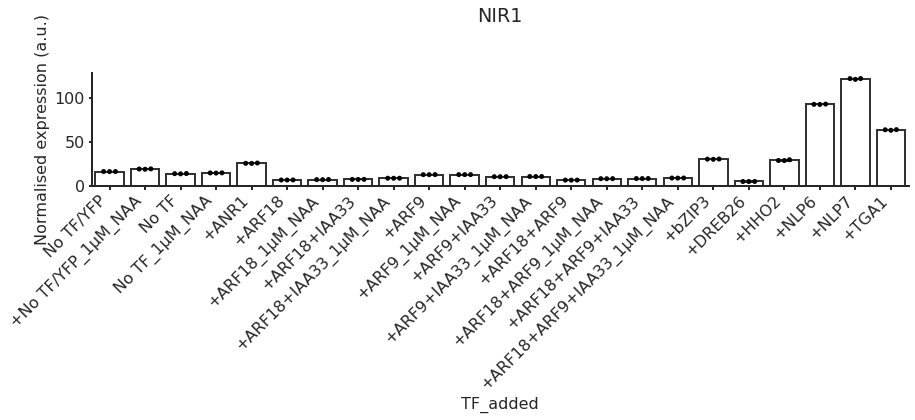

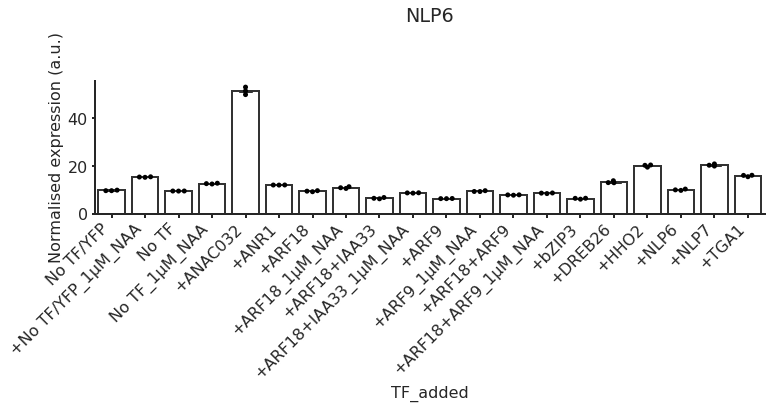

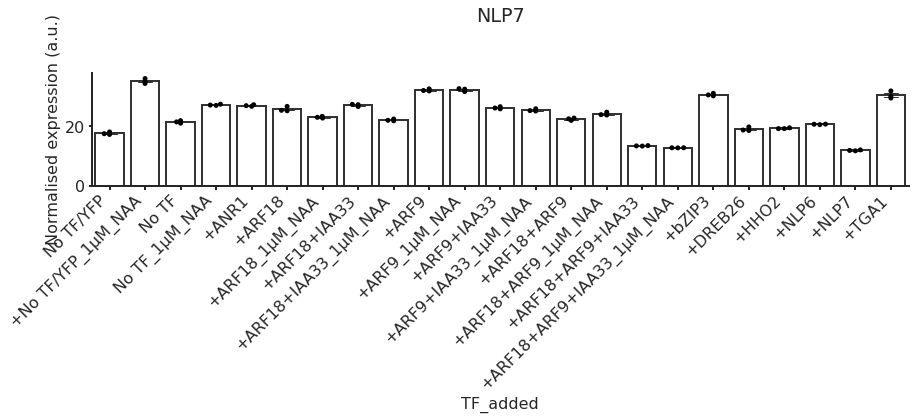

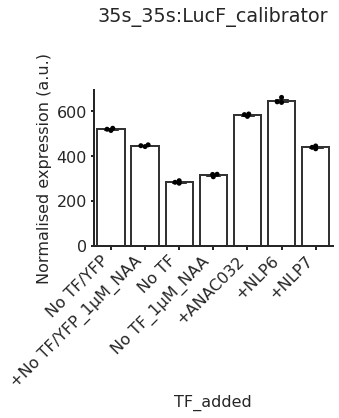

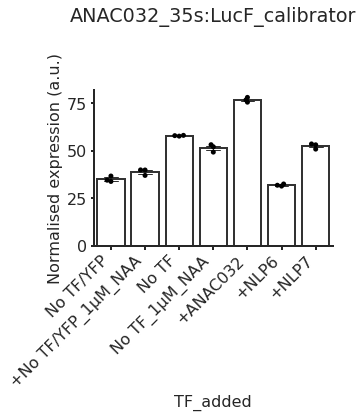

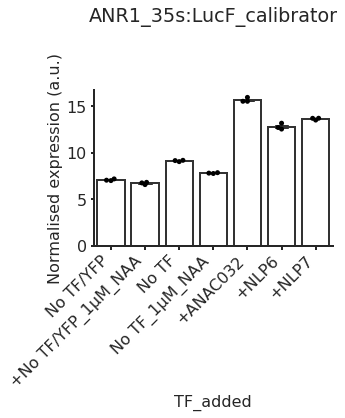

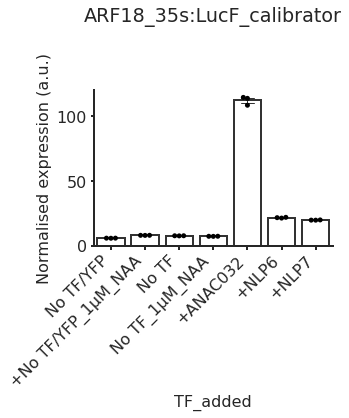

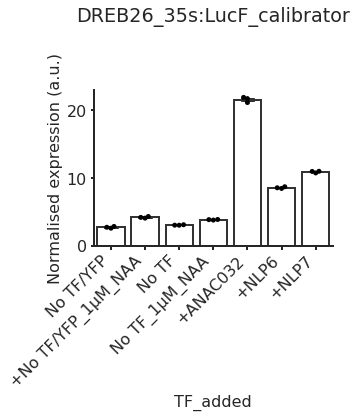

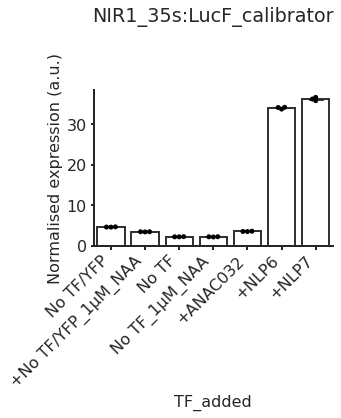

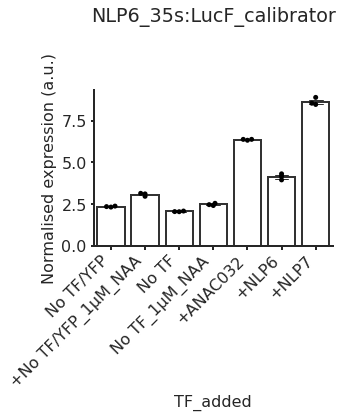

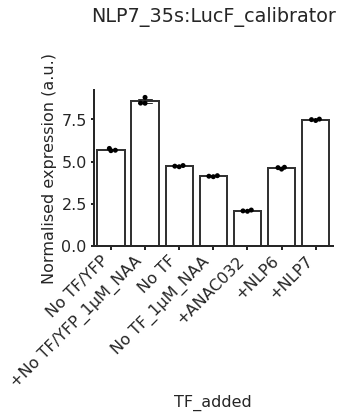

In [72]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
# #plots for promoters with more than 2 Tf categories
# #prom == 'minimal_STAP4'
# #set matplotlib default parameters
# rcParams['xtick.major.width'] = 2
# rcParams['ytick.major.width'] = 2
# rcParams['axes.linewidth'] = 2
# #rcParams['lines.linewidth'] = 2
# #remove top and right lines
# rcParams['axes.spines.top'] = False
# rcParams['axes.spines.right'] = False
# #font size
# rcParams['font.size'] = 16
# for prom in prom_names_plate1:
#     if prom == 'NOS_calibrator' or prom == 'NOS_calibrator_35s:LucF_calibrator' or prom == 'STAP4' or prom == 'minimal_STAP4':
#         pass
#     else:
#         df1 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
#         df2 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
#         #change name of TF added in df2 to minimal_stap4        
#         df2['TF_added'] = 'pSTAP4 no TF'
#         df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
#         TFs_orig =  df.TF_added.unique()
#         TF_order = ['No TF/YFP','+No TF/YFP_1μM_NAA','No TF','No TF_1μM_NAA','+ANAC032','+ANR1','+ARF18','+ARF18_1μM_NAA','+ARF18+IAA33','+ARF18+IAA33_1μM_NAA','+ARF9','+ARF9_1μM_NAA','+ARF9+IAA33','+ARF9+IAA33_1μM_NAA','+ARF18+ARF9','+ARF18+ARF9_1μM_NAA','+ARF18+ARF9+IAA33','+ARF18+ARF9+IAA33_1μM_NAA','+dCas9_activator1','+dCas9_activator2','+dCas9_activator3','+dCpf1_repressor1','+dCpf1_repressor2','+dCpf1_repressor3','+bZIP3','+DREB26','+HHO2','+NLP6','+NLP7','+TGA1','+NLP7+bZIP3','+NLP7+TGA1']
       
#         #sort based on custom order
#         TFs = []
#         for i in range(len(TF_order)):
#             if TF_order[i] in TFs_orig:
#                 TFs+=[TF_order[i]]
#         #print(df)
#         #get length of number of TFs
#         length_tf = len(TFs)
#         #create order and box pairs based on the length of TFs
#         order = []
#         box_pairs = []   
#         for x in range (0, (length_tf)):
#             order.append(TFs[x])
#             if TFs[x] == "No TF":
#                 pass
#             else:
#                 box_pairs.append(('No TF',TFs[x]))
#         #add every combination of box pairs of length 2
#         #box_pairs=list(combinations(order, 2))~
#         box_pairs_all_pvalues = {}
#         for pair in box_pairs:
#             #create series objects
#             TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
#             TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
#         # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
#         # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
#         #equal variance = false so do Welch's T-test
#             results = stats.ttest_ind(TF1, TF2, equal_var=False)
#             #append pvalue to dict
#             box_pairs_all_pvalues[pair] = results.pvalue
#         # box_pairs_significant.append(pair)
#         # p_values.append(results.pvalue)
#         print(f'all pvalues={box_pairs_all_pvalues}')

#         # #filter dict by significance and put in a new dictionary
#         box_pairs_significant = {}
#         for k,v in box_pairs_all_pvalues.items():
#             if v <0.05:
#                 box_pairs_significant[k] = v
                

        
#         # if len(TFs) is 3:
#         #     order = [TFs[0],TFs[1],TFs[2]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
#         # elif len(TFs) is 4:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
#         # elif len(TFs) is 5:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
#         # elif len(TFs) is 6:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
#         # elif len(TFs) is 7:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
#         # elif len(TFs) is 8:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


#         if len(TFs) == 2:
#             #plt.figure()
#             plt.figure(figsize=((length_tf-(length_tf//2)+2),6))
#             order_new = [TFs[0],TFs[1]]
#             fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, facecolor=(1,1,1,1), errcolor=".2", edgecolor=".2", ci=68, errwidth=1,capsize=0.4)
#             sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, order=order,color='black')
#             #fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order_new)


#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
            
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # label box pairs        
#             #box_pairs = [(TFs[0],TFs[1])]
            
#             # make empty list of p_values
#            # p_values = []
#             # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             #     print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)

#             # add stats annotation to the plot
#             # add_stat_annotation(
#             #     fig,
#             #     data=df,
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     order=order_new,
#             #     box_pairs=list(box_pairs_significant.keys()),
#             #     text_format="star",
#             #     loc="outside",
#             #     verbose=2,
#             #     perform_stat_test=False,
#             #     pvalues=list(box_pairs_significant.values()),
#             #     #test='Mann-Whitney',
#             # )
#             # # change axes labels
#             # plt.ylabel('Normalised expression (a.u.)')
#             # #add title
#             # plt.title(prom)
#             # #make xticks diagonal
#             # plt.xticks(rotation=45, ha='right')
#             # #plt.xlabel(x_label)
#             # # tight layout
#             # plt.tight_layout()
#             # # save figure
#             # plt.savefig(
#             #     f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
#             #     format="pdf",
#             #     bbox_inches="tight",
#            # )
#         elif len(TFs) < 2:
#             pass
#         else:
#             print(prom)
#             print(TFs)
#             plt.figure(figsize=((length_tf-(length_tf//2)+1),6))
#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
#             fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, facecolor=(1,1,1,1), errcolor=".2", edgecolor=".2", ci=68, errwidth=1,capsize=0.4)
#             sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, order=order,color='black')
            
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # # label box pairs        
#             # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
#             # # make empty list of p_values
#             # p_values = []
#             # # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             # #    print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)

#             # add stats annotation to the plot


#             #if no significant values, don't add stats annotation
#         # if len(box_pairs_significant.values()) < 1:
#         #     pass
#         # else:
#         #     add_stat_annotation(
#         #         fig,
#         #         data=df,
#         #         x='TF_added',
#         #         y='corrected_luminescence',
#         #         order=order,
#         #         box_pairs=list(box_pairs_significant.keys()),
#         #         text_format="star",
#         #         loc="outside",
#         #         verbose=2,
#         #         perform_stat_test=False,
#         #         pvalues=list(box_pairs_significant.values()),
#         #         #test_short_name="Dunn",
#         #     )

#         # change axes labels
#         plt.ylabel('Normalised expression (a.u.)')
#         #add title
#         plt.title(prom, y=1.4,)
#         #make xticks diagonal
#         plt.xticks(rotation=45, ha='right')
#         #plt.xlabel(x_label)
#         # tight layout
#         plt.tight_layout()
#         # save figure
#         plt.savefig(
#             f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
#             format="pdf",
#             bbox_inches="tight",)
 
            


#             #write to file static image and interactive one
#         # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#         #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#         #  fig.show()

In [63]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
# #plots for promoters with more than 2 Tf categories
# #prom == 'minimal_STAP4'
# #set matplotlib default parameters
# rcParams['xtick.major.width'] = 2
# rcParams['ytick.major.width'] = 2
# rcParams['axes.linewidth'] = 2
# #rcParams['lines.linewidth'] = 2
# #remove top and right lines
# rcParams['axes.spines.top'] = False
# rcParams['axes.spines.right'] = False
# #font size
# rcParams['font.size'] = 16
# for prom in prom_names_plate2:
#     if prom == 'STAP4' or prom == 'NOS_calibrator':
#         pass
#     else:
#         df1 = luminescence_raw_df_plate2[luminescence_raw_df_plate2.Promoter == prom].sort_values("TF_added", ascending=False)
#         df2 = luminescence_raw_df_plate2[luminescence_raw_df_plate2.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
#         #change name of TF added in df2 to minimal_stap4        
#         df2['TF_added'] = 'pSTAP4 no TF'
#         df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
#         TFs_orig =  df.TF_added.unique()
#         TF_order = ['No TF','+No TF_1μM_NAA','+YFP','+YFP_1μM_NAA','+ANAC032','+ANR1','+ARF18','+ARF18_1μM_NAA','+ARF9','+ARF9_1μM_NAA','+ARF18+ARF9','+ARF18+ARF9_1μM_NAA','+bZIP3','+DREB26','+HHO2','+NLP6','+NLP7','+TGA1']
#         #sort based on custom order
#         TFs = []
#         for i in range(len(TF_order)):
#             if TF_order[i] in TFs_orig:
#                 TFs+=[TF_order[i]]
#         #print(df)
#         #get length of number of TFs
#         length_tf = len(TFs)
#         #create order and box pairs based on the length of TFs
#         order = []
#         box_pairs = []   
#         for x in range (0, (length_tf)):
#             order.append(TFs[x])
#             if TFs[x] == "+YFP":
#                 pass
#             else:
#                 box_pairs.append(('+YFP',TFs[x]))
#         #add every combination of box pairs of length 2
#         #box_pairs=list(combinations(order, 2))
#         box_pairs_all_pvalues = {}
#         for pair in box_pairs:
#             #create series objects
#             TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
#             TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
#         # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
#         # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
#         #equal variance = false so do Welch's T-test
#             results = stats.ttest_ind(TF1, TF2, equal_var=False)
#             #append pvalue to dict
#             box_pairs_all_pvalues[pair] = results.pvalue
#         # box_pairs_significant.append(pair)
#         # p_values.append(results.pvalue)
#         print(f'all pvalues={box_pairs_all_pvalues}')

#         # #filter dict by significance and put in a new dictionary
#         box_pairs_significant = {}
#         for k,v in box_pairs_all_pvalues.items():
#             if v <0.05:
#                 box_pairs_significant[k] = v
                

        
#         # if len(TFs) is 3:
#         #     order = [TFs[0],TFs[1],TFs[2]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
#         # elif len(TFs) is 4:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
#         # elif len(TFs) is 5:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
#         # elif len(TFs) is 6:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
#         # elif len(TFs) is 7:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
#         # elif len(TFs) is 8:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


#         if len(TFs) < 3:
#             plt.figure()
#             order = [TFs[0],TFs[1]]
#             fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order)


#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
            
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # label box pairs        
#             box_pairs = [(TFs[0],TFs[1])]
#             # make empty list of p_values
#             p_values = []
#             # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             #     print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)

#             # add stats annotation to the plot
#             add_stat_annotation(
#                 fig,
#                 data=df,
#                 x='TF_added',
#                 y='corrected_luminescence',
#                 order=order,
#                 box_pairs=box_pairs,
#                 text_format="star",
#                 loc="outside",
#                 verbose=2,
#                 #perform_stat_test=False,
#                 #pvalues=p_values,
#                 test='Mann-Whitney',
#             )
#         else:
#             print(prom)
#             print(TFs)
#             plt.figure(figsize=((length_tf-(length_tf//2)+1),6))
#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
#             fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, facecolor=(1,1,1,1), errcolor=".2", edgecolor=".2", ci=68, errwidth=1,capsize=0.4)
#             sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, order=order,color='black')
            
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # # label box pairs        
#             # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
#             # # make empty list of p_values
#             # p_values = []
#             # # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             # #    print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)

#             # add stats annotation to the plot
#             #if no significant values, don't add stats annotation
#             if len(box_pairs_significant.values()) < 1:
#                 pass
#             else:
#                 add_stat_annotation(
#                     fig,
#                     data=df,
#                     x='TF_added',
#                     y='corrected_luminescence',
#                     order=order,
#                     box_pairs=list(box_pairs_significant.keys()),
#                     text_format="star",
#                     loc="outside",
#                     verbose=2,
#                     perform_stat_test=False,
#                     pvalues=list(box_pairs_significant.values()),
#                     #test_short_name="Dunn",
#                 )

#             # change axes labels
#             plt.ylabel('Normalised expression (a.u.)')
#             #add title
#             plt.title(prom)
#             #make xticks diagonal
#             plt.xticks(rotation=45, ha='right')
#             #plt.xlabel(x_label)
#             # tight layout
#             plt.tight_layout()
#             # save figure
#             plt.savefig(
#                 f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate2.pdf',
#                 format="pdf",
#                 bbox_inches="tight",
#             )
            


#             #write to file static image and interactive one
#         # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#         #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#         #  fig.show()

In [213]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
# #plots for promoters 2 Tf categories

# for prom in prom_names_plate1:
#     if prom == 'NOS' or prom == 'STAP4':
#         pass
#     else:
#         df = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
#         TFs =  df.TF_added.unique()
#         print(prom)
#         print(TFs)
#         if len(TFs) is not 2:
#             pass
#         else:
#             plt.figure()
#             order = [TFs[0],TFs[1]]
#             fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order)


#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
            
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # label box pairs        
#             box_pairs = [(TFs[0],TFs[1])]
#             # make empty list of p_values
#             p_values = []
#             # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             #     print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)

#             # add stats annotation to the plot
#             add_stat_annotation(
#                 fig,
#                 data=df,
#                 x='TF_added',
#                 y='corrected_luminescence',
#                 order=order,
#                 box_pairs=box_pairs,
#                 text_format="star",
#                 loc="outside",
#                 verbose=2,
#                 #perform_stat_test=False,
#                 #pvalues=p_values,
#                 test='Mann-Whitney',
#             )
#             # change axes labels
#             plt.ylabel('Mean luminescence (a.u.)')
#             #plt.xlabel(x_label)
#             # tight layout
#             plt.tight_layout()
#             # save figure
            
#             plt.savefig(
#                 f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
#                 format="pdf",
#                 bbox_inches="tight",
#             )           


#         #write to file static image and interactive one
#        # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#       #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#       #  fig.show()

In [214]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
# #plots for promoters 2 Tf categories

# for prom in prom_names_plate2:
#     if prom == 'NOS' or prom == 'STAP4':
#         pass
#     else:
#         df = luminescence_raw_df_plate2[luminescence_raw_df_plate2.Promoter == prom].sort_values("TF_added", ascending=False)
#         TFs =  df.TF_added.unique()
#         print(prom)
#         print(TFs)
#         if len(TFs) is not 2:
#             pass
#         else:
#             plt.figure()
#             order = [TFs[0],TFs[1]]
#             fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order)


#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
            
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # label box pairs        
#             box_pairs = [(TFs[0],TFs[1])]
#             # make empty list of p_values
#             p_values = []
#             # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             #     print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)

#             # add stats annotation to the plot
#             add_stat_annotation(
#                 fig,
#                 data=df,
#                 x='TF_added',
#                 y='corrected_luminescence',
#                 order=order,
#                 box_pairs=box_pairs,
#                 text_format="star",
#                 loc="outside",
#                 verbose=2,
#                 #perform_stat_test=False,
#                 #pvalues=p_values,
#                 test='Mann-Whitney',
#             )
#             # change axes labels
#             plt.ylabel('Mean luminescence (a.u.)')
#             #plt.xlabel(x_label)
#             # tight layout
#             plt.tight_layout()
#             # save figure
            
#             plt.savefig(
#                 f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate2.pdf',
#                 format="pdf",
#                 bbox_inches="tight",
#             )           


#         #write to file static image and interactive one
#        # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#       #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#       #  fig.show()

In [ ]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
# #plots for promoters with more than 2 Tf categories
# #prom == 'minimal_STAP4'
# for prom in prom_names_plate1:
#     if prom == 'NOS' or prom == 'STAP4':
#         pass
#     else:
#         df1 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
#         df2 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
#         #change name of TF added in df2 to minimal_stap4        
#         df2['TF_added'] = 'pSTAP4 no TF'
#         df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
#         TFs =  df.TF_added.unique()
#         #print(df)
#         #get length of number of TFs
#         length_tf = len(TFs)
#         #create order and box pairs based on the length of TFs
#         order = []
#         box_pairs = []   
#         for x in range (0, (length_tf)):
#             order.append(TFs[x])
#             if TFs[x] == "No TF":
#                 pass
#             else:
#                 box_pairs.append(('No TF',TFs[x]))
#         #add every combination of box pairs of length 2
#         #box_pairs=list(combinations(order, 2))
#         box_pairs_all_pvalues = {}
#         for pair in box_pairs:
#             #create series objects
#             TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
#             TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
#         # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
#         # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
#         #equal variance = false so do Welch's T-test
#             results = stats.ttest_ind(TF1, TF2, equal_var=False)
#             #append pvalue to dict
#             box_pairs_all_pvalues[pair] = results.pvalue
#         # box_pairs_significant.append(pair)
#         # p_values.append(results.pvalue)
#         print(f'all pvalues={box_pairs_all_pvalues}')

#         # #filter dict by significance and put in a new dictionary
#         box_pairs_significant = {}
#         for k,v in box_pairs_all_pvalues.items():
#             if v <0.05:
#                 box_pairs_significant[k] = v
                

        
#         # if len(TFs) is 3:
#         #     order = [TFs[0],TFs[1],TFs[2]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
#         # elif len(TFs) is 4:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
#         # elif len(TFs) is 5:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
#         # elif len(TFs) is 6:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
#         # elif len(TFs) is 7:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
#         # elif len(TFs) is 8:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


#         if len(TFs) < 3:
#             pass
#         else:
#             print(prom)
#             print(TFs)
#             plt.figure(figsize=((length_tf+8),5))
#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
#             fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, order=order, hue='condition')
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # # label box pairs        
#             # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
#             # # make empty list of p_values
#             # p_values = []
#             # # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             # #    print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)
#             #print("valuesSAM = " + str(box_pairs_significant.values()))
#             # add stats annotation to the plot
#             #if no significant values, don't add stats annotation
#             if len(box_pairs_significant.values()) < 1:
#                 pass
#             else:
#                 add_stat_annotation(
#                     fig,
#                     data=df,
#                     x='TF_added',
#                     y='corrected_luminescence',
#                     order=order,
#                     box_pairs=list(box_pairs_significant.keys()),
#                     text_format="star",
#                     loc="outside",
#                     verbose=2,
#                     perform_stat_test=False,
#                     pvalues=list(box_pairs_significant.values()),
#                     #test_short_name="Dunn",
#                 )
#             # change axes labels
#             plt.ylabel('Luminescence (a.u.)')
#             #add title
#             plt.title(prom)
#             #plt.xlabel(x_label)
#             # tight layout
#             plt.tight_layout()
#             # save figure
#             plt.savefig(
#                 f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
#                 format="pdf",
#                 bbox_inches="tight",
#             )
            


#             #write to file static image and interactive one
#         # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#         #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#         #  fig.show()

### test normality

In [203]:
#returns test statistic, p-value
for name1 in prom_names_plate1:
    for name in names_plate1:
        print(name1,'{}: {}'.format(name, stats.shapiro(luminescence_raw_df_plate1['nluc/fluc'][luminescence_raw_df_plate1.TF_added == name])))


NOS +No TF_1μM_NAA: ShapiroResult(statistic=0.6021087169647217, pvalue=3.555633287799509e-10)
NOS +ARF18+IAA33_1μM_NAA: ShapiroResult(statistic=0.5674434304237366, pvalue=2.729845505200501e-07)
NOS +ANAC032: ShapiroResult(statistic=0.6649079918861389, pvalue=8.30073787483343e-08)
NOS +NLP6: ShapiroResult(statistic=0.5025386214256287, pvalue=1.581822520191345e-11)
NOS +ARF9: ShapiroResult(statistic=0.633334755897522, pvalue=4.5249385038914625e-06)
NOS +ARF9_1μM_NAA: ShapiroResult(statistic=0.6098078489303589, pvalue=2.5041554181370884e-06)
NOS +NLP7: ShapiroResult(statistic=0.5536598563194275, pvalue=7.369764520870348e-11)
NOS +ARF18: ShapiroResult(statistic=0.5843394994735718, pvalue=4.150164727434458e-07)
NOS +ARF18_1μM_NAA: ShapiroResult(statistic=0.5886361002922058, pvalue=4.624382086149126e-07)
NOS +No TF/YFP_1μM_NAA: ShapiroResult(statistic=0.5478658080101013, pvalue=6.153911408235402e-11)
NOS No TF/YFP: ShapiroResult(statistic=0.5933141708374023, pvalue=8.104313119032536e-13)
NOS

#### not normal

In [202]:
#test variance
stats.levene(luminescence_raw_df['nluc/fluc'][luminescence_raw_df.TF_added == names[0]], 
               luminescence_raw_df['nluc/fluc'][luminescence_raw_df.TF_added == names[1]])

NameError: name 'luminescence_raw_df' is not defined

In [ ]:
test = luminescence_raw_df.groupby('Promoter')

In [ ]:
test

# one-way ANOVA: scipy.stats.kruskal

In [80]:
for name in names:
    print(name)

No TF
+ARF9
+HHO2
+ANR1
+bZIP3
+TGA1
+ARF18+ARF9
+ARF18
+ANAC032
+NLP7
+DREB26
+NLP6


In [81]:
#luminescence anova
for promoter, value in test:
    if promoter == 'ANAC032':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'DREB26'],
                value['corrected_luminescence'][value.TF_added == 'ARF18'],
                value['corrected_luminescence'][value.TF_added == 'DREB26+ARF18']))
    if promoter == 'ANR1':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'ANR1'],
                value['corrected_luminescence'][value.TF_added == 'NLP7'],
                value['corrected_luminescence'][value.TF_added == 'ARF18'],
                value['corrected_luminescence'][value.TF_added == 'DREB26']))
    if promoter == 'ARF18':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'NLP7'],
                value['corrected_luminescence'][value.TF_added == 'DREB26']))
    if promoter == 'NLP6':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'ANR1'],                
                value['corrected_luminescence'][value.TF_added == 'ARF18'],
                value['corrected_luminescence'][value.TF_added == 'DREB26']))
    if promoter == 'DREB26':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],                
                value['corrected_luminescence'][value.TF_added == 'ARF18'],
               ))
    if promoter == 'NLP7':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'ANR1'],
                value['corrected_luminescence'][value.TF_added == 'NLP7'],                
                value['corrected_luminescence'][value.TF_added == 'DREB26'],
                value['corrected_luminescence'][value.TF_added == 'ANAC032'],))
    
    if promoter == 'NIR1':
            
            print(promoter)     
            print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'NLP6+NLP7'],
                value['corrected_luminescence'][value.TF_added == 'NLP7'],                
                value['corrected_luminescence'][value.TF_added == 'DREB26'],
                value['corrected_luminescence'][value.TF_added == 'NLP6+NLP7+DREB26'],
                value['corrected_luminescence'][value.TF_added == 'NLP6']))        


ANAC032
F_onewayResult(statistic=nan, pvalue=nan)
ANR1
F_onewayResult(statistic=nan, pvalue=nan)
ARF18
F_onewayResult(statistic=nan, pvalue=nan)
DREB26
F_onewayResult(statistic=nan, pvalue=nan)
NIR1
F_onewayResult(statistic=nan, pvalue=nan)
NLP6
F_onewayResult(statistic=nan, pvalue=nan)
NLP7
F_onewayResult(statistic=nan, pvalue=nan)


/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/scipy/stats/stats.py:3612: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


In [82]:
df = luminescence_raw_df
#First rerun NIR1 it as a GLM
NIR1 = df[df.Promoter == 'NIR1']  
results = ols('corrected_luminescence ~ C(TF_added)', data=NIR1).fit()
results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     corrected_luminescence   R-squared:                       1.000
Model:                                OLS   Adj. R-squared:                  1.000
Method:                     Least Squares   F-statistic:                 1.865e+04
Date:                    Mon, 02 Aug 2021   Prob (F-statistic):           2.91e-59
Time:                            15:43:24   Log-Likelihood:                -32.491
No. Observations:                      45   AIC:                             88.98
Df Residuals:                          33   BIC:                             110.7
Df Model:                              11                                         
Covariance Type:                nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      6.7245      0.336     20.023      0.000       6.041       7.408
C(TF_added)[T.+ANR1]          -0.9453      0.475     -1.990      0.055      -1.912       0.021
C(TF_added)[T.+ARF18]         -5.5688      0.411    -13.539      0.000      -6.406      -4.732
C(TF_added)[T.+ARF18+ARF9]    -5.3439      0.411    -12.993      0.000      -6.181      -4.507
C(TF_added)[T.+ARF9]          -4.6423      0.411    -11.287      0.000      -5.479      -3.806
C(TF_added)[T.+DREB26]        -2.4859      0.475     -5.234      0.000      -3.452      -1.520
C(TF_added)[T.+HHO2]          -3.3290      0.475     -7.009      0.000      -4.295      -2.363
C(TF_added)[T.+NLP6]          51.5304      0.475    108.500      0.000      50.564      52.497
C(TF_added)[T.+NLP7]         148.5001      0.475    312.675      0.000     147.534     149.466
C(TF_added)[T.+TGA1]           2.2719      0.475      4.784      0.000       1.306       3.238
C(TF_added)[T.+bZIP3]          0.7928      0.475      1.669      0.105      -0.173       1.759
C(TF_added)[T.No TF]          -2.3599      0.475     -4.969      0.000      -3.326      -1.394
==============================================================================
Omnibus:                       52.636   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              560.059
Skew:                           2.459   Prob(JB):                    2.43e-122
Kurtosis:                      19.568   Cond. No.                         14.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
# #make anova table for NIR1
# aov_table = sm.stats.anova_lm(results, typ=2)
# aov_table

In [84]:
# #pairwise tukey posthoc test for NIR1

    
# mc = MultiComparison(NIR1['corrected_luminescence'], NIR1['TF_added'])
# mc_results = mc.tukeyhsd()
# print(mc_results)

In [85]:
rp.summary_cont(NIR1['corrected_luminescence'].groupby(NIR1['TF_added']))

,N,Mean,SD,SE,95% Conf.,Interval
TF_added,,,,,,
+ANAC032,3,6.724485,0.023889,0.013793,6.691376,6.757594
+ANR1,3,5.779182,0.026019,0.015022,5.743122,5.815242
+ARF18,6,1.155667,0.057076,0.023301,1.105638,1.205697
+ARF18+ARF9,6,1.380576,0.151005,0.061647,1.248215,1.512937
+ARF9,6,2.082164,0.081723,0.033363,2.010530,2.153797
+DREB26,3,4.238549,0.044260,0.025553,4.177208,4.299890
+HHO2,3,3.395499,0.054186,0.031284,3.320401,3.470596
+NLP6,3,58.254933,0.322122,0.185977,57.808494,58.701372
+NLP7,3,155.224614,2.281168,1.317033,152.063076,158.386152


In [86]:
ANR1 = df[df.Promoter == 'ANR1']
rp.summary_cont(ANR1['corrected_luminescence'].groupby(ANR1['TF_added']))


,N,Mean,SD,SE,95% Conf.,Interval
TF_added,,,,,,
+ANAC032,3,15.083662,0.344479,0.198885,14.606239,15.561086
+ANR1,3,9.594051,0.196969,0.113720,9.321065,9.867036
+ARF18,6,3.382318,0.729296,0.297734,2.743062,4.021574
+ARF18+ARF9,6,3.770632,0.431280,0.176069,3.392599,4.148666
+ARF9,6,3.275840,0.127926,0.052225,3.163708,3.387972
+DREB26,3,19.188573,0.481732,0.278128,18.520927,19.856219
+HHO2,3,11.415834,0.268452,0.154991,11.043779,11.787889
+NLP6,3,10.353489,0.269201,0.155423,9.980396,10.726582
+NLP7,3,7.897732,0.168792,0.097452,7.663798,8.131666


In [87]:
for promoter, value in test:
    print('\033[1m' +promoter + '\033[0m')
    print(kruskal(data=df[df.Promoter == promoter], dv='corrected_luminescence', between='TF_added'))
    print('')

NOS
           Source  ddof1    H  p-unc
Kruskal  TF_added      0  0.0    NaN

STAP4
           Source  ddof1    H  p-unc
Kruskal  TF_added      0  0.0    NaN

35s


ZeroDivisionError: division by zero

In [ ]:
#run Dunn's post-hoc test
#ANR1
sp.posthoc_dunn(df[df.Promoter == 'ANR1'], val_col='corrected_luminescence', group_col='TF_added', p_adjust='bonferroni')

,ANR1,ARF18,DREB26,NLP7,None
ANR1,-1.000000,1.000000,0.071163,1.000000,1.000000
ARF18,1.000000,-1.000000,1.000000,0.454646,1.000000
DREB26,0.071163,1.000000,-1.000000,0.003175,1.000000
NLP7,1.000000,0.454646,0.003175,-1.000000,0.535796
None,1.000000,1.000000,1.000000,0.535796,-1.000000


In [ ]:
#NIR1 post-hoc test
sp.posthoc_dunn(df[df.Promoter == 'NIR1'], val_col='corrected_luminescence', group_col='TF_added', p_adjust='bonferroni')

,DREB26,NLP6,NLP6+NLP7,NLP6+NLP7+DREB26,NLP7,None
DREB26,-1.000000,0.537726,0.021630,0.052771,0.017535,1.000000
NLP6,0.537726,-1.000000,1.000000,1.000000,1.000000,1.000000
NLP6+NLP7,0.021630,1.000000,-1.000000,1.000000,1.000000,0.070083
NLP6+NLP7+DREB26,0.052771,1.000000,1.000000,-1.000000,1.000000,0.206551
NLP7,0.017535,1.000000,1.000000,1.000000,-1.000000,0.094729
None,1.000000,1.000000,0.070083,0.206551,0.094729,-1.000000
